In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)
import h2o
from h2o.automl import H2OAutoML

In [2]:
train_df = pd.read_csv("./jinnan_round1_train_20181227.csv", encoding = 'gb18030')
test_df = pd.read_csv("./jinnan_round1_testA_20181227.csv", encoding = 'gb18030')

In [3]:
views = []
for col in train_df.columns:
    views.append((col, train_df[col].nunique(), train_df[col].isnull().sum() * 100 / train_df.shape[0], train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, train_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,96,96.991404,float64
7,A7,75,89,89.326648,object
8,A8,8,89,89.326648,float64
39,B11,37,60,60.816619,object
38,B10,174,17,17.478510,object
3,A3,3,3,95.702006,float64
0,sample_id,1396,0,0.071633,object
33,B5,60,0,17.550143,object
26,A26,87,0,19.054441,object
27,A27,13,0,45.128940,int64


In [4]:
views = []
for col in test_df.columns:
    views.append((col, test_df[col].nunique(), test_df[col].isnull().sum() * 100 / test_df.shape[0], test_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, test_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,98,98.000000,float64
7,A7,15,88,88.000000,object
8,A8,2,88,88.000000,float64
39,B11,11,59,59.333333,object
38,B10,50,14,14.666667,object
3,A3,2,2,97.333333,float64
0,sample_id,150,0,0.666667,object
32,B4,51,0,20.666667,object
26,A26,41,0,21.333333,object
27,A27,11,0,47.333333,int64


In [5]:
for df in [train_df, test_df]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

features = list(train_df.columns)
for col in train_df.columns:
    rate = train_df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        features.remove(col)
train_df = train_df[features]
features.remove('score')
test_df = test_df[features]

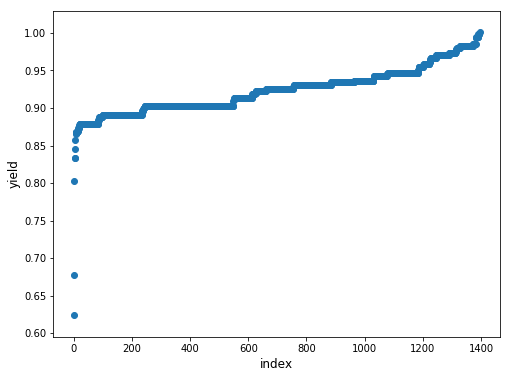

In [6]:
target_col = 'score'
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

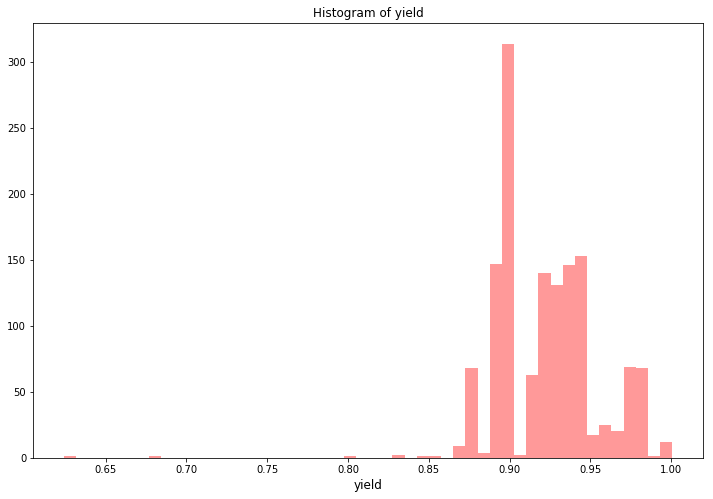

In [7]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [8]:
train_df = train_df[train_df[target_col]>0.87]

In [9]:
def TimeToInt(t, previous = 0):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
        if tm < previous:
            tm += 24
    except:
        return (30*60)/3600
    
    return tm

def TimeToDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1
    try:
        duration = (int(eh)*60+int(em)-int(sm)-int(sh)*60)/60
        if duration < 0:
            duration += 24
        return duration
    except:
        return 0

def Between(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    duration = 0
    try:
        duration = t1 - t2
        if duration < 0:
            duration += 24
    except:
        duration = 0
    return duration

def getBeforeTime(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1       
    try:
        tm = (int(sh)*3600+int(sm)*60)/3600
    except:
        if se=='19:-20:05':
            return (19*3600+5*60)/3600
        elif se=='15:00-1600':
            return 15*3600/3600       
    return tm

def adjust(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    if t1 < t2:
        return t1 + 24
    return t1

def getAfterTime(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    if t1 < 0 or  t2 < 0:
        return -1
    return t1 + t2

In [10]:
target = train_df['score']
del train_df['score']
data = pd.concat([train_df,test_df],axis=0,ignore_index=True)
data = data.fillna(-1)
#del data['sample_id']
data['sample_id'] = data['sample_id'].apply(lambda x: int(x.split('_')[1]))

In [11]:
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    data[f] = data[f].apply(TimeToInt)

In [12]:
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_duration'] = data.apply(lambda data: TimeToDuration(data[f]), axis=1)

for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_before_time'] = data.apply(lambda data: getBeforeTime(data[f]), axis=1)
    
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_after_time'] = data.apply(lambda data: getAfterTime(data[f+'_before_time'], data[f+'_duration']), axis=1)

In [13]:
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A9'],['A14', 'A11'],['A16', 'A14'],['A24', 'A16'],['A26', 'A24'],['B5', 'A26'],['B7', 'B5']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)

for f in [['A20_before_time','A16'],['A28_before_time', 'A26'],['B4_before_time','A28_before_time'],['B9_before_time', 'A5'],['B10_before_time','A5'],['B11_before_time','A5']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)
    
for f in [['A20_after_time','A20_before_time'],['A28_after_time', 'A28_before_time'],['B4_after_time','B4_before_time'],['B9_after_time', 'B9_before_time'],['B10_after_time','B10_before_time'],['B11_after_time','B11_before_time']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)

In [14]:
for f in [['A20_before_time','A5'],['A28_before_time', 'A5'],['B4_before_time','A5'],['B9_before_time', 'A5'],['B10_before_time','A5'],['B11_before_time','A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A20_after_time','A5'],['A28_after_time', 'A5'],['B4_after_time','A5'],['B9_after_time', 'A5'],['B10_after_time','A5'],['B11_after_time','A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A5'],['A14', 'A5'],['A16', 'A5'],['A24', 'A5'],['A26', 'A5'],['B5', 'A5'],['B7', 'A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A9'],['A14', 'A11'],['A16', 'A14'],['A24', 'A16'],['A26', 'A24'],['B5', 'A26'],['B7', 'B5']]:
    data[f[0]+'duration'] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in ['A20','A28','B4','B9','B10','B11']:
    del data[f]

In [15]:
categorical_columns = [f for f in data.columns]
for f in categorical_columns:
    cate_rate = data[f].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        data[f+'_median'] = data[f].median()
        data[f+'_std'] = data[f].std()
        data[f+'_max'] = data[f].max()
        data[f+'_min'] = data[f].min()
        data[f+'_**2'] = data[f].min()**2
        data[f+'_**1/2'] = data[f].min()**(1/2)
    
print(data.shape)

(1531, 347)


In [16]:
def merge_median(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].median()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_mean(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].mean()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_max(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].max()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_min(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].min()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_std(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].std()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_div(t1, t2):
    if t2 == 0:
        return 0
    return t1 / t2

In [17]:
data = merge_median(data, ['A8'], 'A7', 'A8_A7_median')
data = merge_median(data, ['A10'], 'A9', 'A10_A9_median')
data = merge_median(data, ['A12'], 'A11', 'A12_A11_median')
data = merge_median(data, ['A15'], 'A14', 'A15_A14_median')
data = merge_median(data, ['A17'], 'A16', 'A17_A16_median')
data = merge_median(data, ['A25'], 'A24', 'A25_A24_median')
data = merge_median(data, ['A27'], 'A26', 'A27_A26_median')
data = merge_median(data, ['B6'], 'B5', 'B6_B5_median')
data = merge_median(data, ['B8'], 'B7', 'B8_B7_median')

data = merge_mean(data, ['A8'], 'A7', 'A8_A7_mean')
data = merge_mean(data, ['A10'], 'A9', 'A10_A9_mean')
data = merge_mean(data, ['A12'], 'A11', 'A12_A11_mean')
data = merge_mean(data, ['A15'], 'A14', 'A15_A14_mean')
data = merge_mean(data, ['A17'], 'A16', 'A17_A16_mean')
data = merge_mean(data, ['A25'], 'A24', 'A25_A24_mean')
data = merge_mean(data, ['A27'], 'A26', 'A27_A26_mean')
data = merge_mean(data, ['B6'], 'B5', 'B6_B5_mean')
data = merge_mean(data, ['B8'], 'B7', 'B8_B7_mean')

data = merge_max(data, ['A8'], 'A7', 'A8_A7_max')
data = merge_max(data, ['A10'], 'A9', 'A10_A9_max')
data = merge_max(data, ['A12'], 'A11', 'A12_A11_max')
data = merge_max(data, ['A15'], 'A14', 'A15_A14_max')
data = merge_max(data, ['A17'], 'A16', 'A17_A16_max')
data = merge_max(data, ['A25'], 'A24', 'A25_A24_max')
data = merge_max(data, ['A27'], 'A26', 'A27_A26_max')
data = merge_max(data, ['B6'], 'B5', 'B6_B5_max')
data = merge_max(data, ['B8'], 'B7', 'B8_B7_max')

data = merge_min(data, ['A8'], 'A7', 'A8_A7_min')
data = merge_min(data, ['A10'], 'A9', 'A10_A9_min')
data = merge_min(data, ['A12'], 'A11', 'A12_A11_min')
data = merge_min(data, ['A15'], 'A14', 'A15_A14_min')
data = merge_min(data, ['A17'], 'A16', 'A17_A16_min')
data = merge_min(data, ['A25'], 'A24', 'A25_A24_min')
data = merge_min(data, ['A27'], 'A26', 'A27_A26_min')
data = merge_min(data, ['B6'], 'B5', 'B6_B5_min')
data = merge_min(data, ['B8'], 'B7', 'B8_B7_min')

data = merge_std(data, ['A8'], 'A7', 'A8_A7_std')
data = merge_std(data, ['A10'], 'A9', 'A10_A9_std')
data = merge_std(data, ['A12'], 'A11', 'A12_A11_std')
data = merge_std(data, ['A15'], 'A14', 'A15_A14_std')
data = merge_std(data, ['A17'], 'A16', 'A17_A16_std')
data = merge_std(data, ['A25'], 'A24', 'A25_A24_std')
data = merge_std(data, ['A27'], 'A26', 'A27_A26_std')
data = merge_std(data, ['B6'], 'B5', 'B6_B5_std')
data = merge_std(data, ['B8'], 'B7', 'B8_B7_std')

data['A8_A7_div'] = data.apply(lambda df: merge_div(df['A8'], df['A7']), axis=1)
data['A10_A9_div'] = data.apply(lambda df: merge_div(df['A10'], df['A9']), axis=1)
data['A12_A11_div'] = data.apply(lambda df: merge_div(df['A12'], df['A11']), axis=1)
data['A15_A14_div'] = data.apply(lambda df: merge_div(df['A15'], df['A14']), axis=1)
data['A17_A16_div'] = data.apply(lambda df: merge_div(df['A17'], df['A16']), axis=1)
data['A25_A24_div'] = data.apply(lambda df: merge_div(df['A25'], df['A24']), axis=1)
data['A27_A26_div'] = data.apply(lambda df: merge_div(df['A27'], df['A26']), axis=1)
data['B6_B5_div'] = data.apply(lambda df: merge_div(df['B6'], df['B5']), axis=1)
data['B8_B7_div'] = data.apply(lambda df: merge_div(df['B8'], df['B7']), axis=1)

In [18]:
data.head()

,sample_id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A22,A24,A25,A26,A27,B1,B5,B6,B7,B8,B12,B14,A20_duration,A28_duration,B4_duration,B9_duration,B10_duration,B11_duration,A20_before_time,A28_before_time,B4_before_time,B9_before_time,B10_before_time,B11_before_time,A20_after_time,A28_after_time,B4_after_time,B9_after_time,B10_after_time,B11_after_time,A7duration,A9duration,A11duration,A14duration,A16duration,A24duration,A26duration,B5duration,B7duration,sample_id_median,sample_id_std,sample_id_max,sample_id_min,sample_id_**2,sample_id_**1/2,A5_median,A5_std,A5_max,A5_min,A5_**2,A5_**1/2,A6_median,A6_std,A6_max,A6_min,A6_**2,A6_**1/2,A7_median,A7_std,A7_max,A7_min,A7_**2,A7_**1/2,A8_median,A8_std,A8_max,A8_min,A8_**2,A8_**1/2,A9_median,A9_std,A9_max,A9_min,A9_**2,A9_**1/2,A10_median,A10_std,A10_max,A10_min,A10_**2,A10_**1/2,A11_median,A11_std,A11_max,A11_min,A11_**2,A11_**1/2,A12_median,A12_std,A12_max,A12_min,A12_**2,A12_**1/2,A14_median,A14_std,A14_max,A14_min,A14_**2,A14_**1/2,A15_median,A15_std,A15_max,A15_min,A15_**2,A15_**1/2,A16_median,A16_std,A16_max,A16_min,A16_**2,A16_**1/2,A17_median,A17_std,A17_max,A17_min,A17_**2,A17_**1/2,A19_median,A19_std,A19_max,A19_min,A19_**2,A19_**1/2,A22_median,A22_std,A22_max,A22_min,A22_**2,A22_**1/2,A24_median,A24_std,A24_max,A24_min,A24_**2,A24_**1/2,A25_median,A25_std,A25_max,A25_min,A25_**2,A25_**1/2,A26_median,A26_std,A26_max,A26_min,A26_**2,A26_**1/2,A27_median,A27_std,A27_max,A27_min,A27_**2,A27_**1/2,B1_median,B1_std,B1_max,B1_min,B1_**2,B1_**1/2,B5_median,B5_std,B5_max,B5_min,B5_**2,B5_**1/2,B6_median,B6_std,B6_max,B6_min,B6_**2,B6_**1/2,B7_median,B7_std,B7_max,B7_min,B7_**2,B7_**1/2,B8_median,B8_std,B8_max,B8_min,B8_**2,B8_**1/2,B12_median,B12_std,B12_max,B12_min,B12_**2,B12_**1/2,B14_median,B14_std,B14_max,B14_min,B14_**2,B14_**1/2,A20_duration_median,A20_duration_std,A20_duration_max,A20_duration_min,A20_duration_**2,A20_duration_**1/2,A28_duration_median,A28_duration_std,A28_duration_max,A28_duration_min,A28_duration_**2,A28_duration_**1/2,B9_duration_median,B9_duration_std,B9_duration_max,B9_duration_min,B9_duration_**2,B9_duration_**1/2,B10_duration_median,B10_duration_std,B10_duration_max,B10_duration_min,B10_duration_**2,B10_duration_**1/2,B11_duration_median,B11_duration_std,B11_duration_max,B11_duration_min,B11_duration_**2,B11_duration_**1/2,A20_before_time_median,A20_before_time_std,A20_before_time_max,A20_before_time_min,A20_before_time_**2,A20_before_time_**1/2,A28_before_time_median,A28_before_time_std,A28_before_time_max,A28_before_time_min,A28_before_time_**2,A28_before_time_**1/2,B4_before_time_median,B4_before_time_std,B4_before_time_max,B4_before_time_min,B4_before_time_**2,B4_before_time_**1/2,B9_before_time_median,B9_before_time_std,B9_before_time_max,B9_before_time_min,B9_before_time_**2,B9_before_time_**1/2,B10_before_time_median,B10_before_time_std,B10_before_time_max,B10_before_time_min,B10_before_time_**2,B10_before_time_**1/2,B11_before_time_median,B11_before_time_std,B11_before_time_max,B11_before_time_min,B11_before_time_**2,B11_before_time_**1/2,A20_after_time_median,A20_after_time_std,A20_after_time_max,A20_after_time_min,A20_after_time_**2,A20_after_time_**1/2,A28_after_time_median,A28_after_time_std,A28_after_time_max,A28_after_time_min,A28_after_time_**2,A28_after_time_**1/2,B4_after_time_median,B4_after_time_std,B4_after_time_max,B4_after_time_min,B4_after_time_**2,B4_after_time_**1/2,B9_after_time_median,B9_after_time_std,B9_after_time_max,B9_after_time_min,B9_after_time_**2,B9_after_time_**1/2,B10_after_time_median,B10_after_time_std,B10_after_time_max,B10_after_time_min,B10_after_time_**2,B10_after_time_**1/2,B11_after_time_median,B11_after_time_std,B11_after_time_max,B11_after_time_min,B11_after_time_**2,B11_after_time_**1/2,A7duration_median,A7duration_std,A7duration_max,A7duration_min,A7duration_**2,A7duration_**1/2,A9duration_median,A9duration_std,A9duration_max,A9duration_min,A9duration_**2,A9duration_**1/2,A24duration_median,A24du

In [19]:
categorical_columns = [f for f in data.columns if f not in ['sample_id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [20]:
data.fillna(-1, inplace=True)
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train_df.shape[0]]
test  = data[train_df.shape[0]:]
print(train.shape)
print(test.shape)

(1381, 401)
(150, 401)


In [21]:
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_columns = []
for f1 in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if rate < 0.90:
        for f2 in li:
            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
            mean_columns.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            train[col_name] = train['B14'].map(order_label)
            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
            if miss_rate > 0:
                train = train.drop([col_name], axis=1)
                mean_columns.remove(col_name)
            else:
                test[col_name] = test['B14'].map(order_label)
                
train.drop(li, axis=1, inplace=True)
print(train.shape)
print(test.shape)

(1381, 667)
(150, 666)


In [22]:
'''
h2o.init(max_mem_size='64G')
train_h2o = h2o.H2OFrame(train)

feature_name = [i for i in train.columns if i not in ['sample_id','target']]
x = feature_name
y = 'target'

aml = H2OAutoML(max_models=30, seed=2019, max_runtime_secs=300)
aml.train(x=feature_name, y=y, training_frame=train_h2o)

lb = aml.leaderboard
lb.head(rows=lb.nrows)

test_h2o = h2o.H2OFrame(test)
automl_predictions = aml.leader.predict(test_h2o).as_data_frame().values.flatten()

sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = automl_predictions
#sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("zw_automl_submission.csv", index=False, header=None)
'''

'\nh2o.init(max_mem_size=\'64G\')\ntrain_h2o = h2o.H2OFrame(train)\n\nfeature_name = [i for i in train.columns if i not in [\'sample_id\',\'target\']]\nx = feature_name\ny = \'target\'\n\naml = H2OAutoML(max_models=30, seed=2019, max_runtime_secs=300)\naml.train(x=feature_name, y=y, training_frame=train_h2o)\n\nlb = aml.leaderboard\nlb.head(rows=lb.nrows)\n\ntest_h2o = h2o.H2OFrame(test)\nautoml_predictions = aml.leader.predict(test_h2o).as_data_frame().values.flatten()\n\nsub_df = pd.read_csv(\'submission.csv\', header=None)\nsub_df[1] = automl_predictions\n#sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))\nsub_df.to_csv("zw_automl_submission.csv", index=False, header=None)\n'

In [23]:
X_train = train[mean_columns+numerical_columns].values
X_test = test[mean_columns+numerical_columns].values

# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

(1381, 2287)
(150, 2287)


In [24]:
train.head()

,sample_id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A22,A24,A25,A26,A27,B1,B5,B6,B7,B8,B12,B14,A20_duration,A28_duration,B4_duration,B9_duration,B10_duration,B11_duration,A20_before_time,A28_before_time,B4_before_time,B9_before_time,B10_before_time,B11_before_time,A20_after_time,A28_after_time,B4_after_time,B9_after_time,B10_after_time,B11_after_time,A7duration,A9duration,A11duration,A14duration,A16duration,A24duration,A26duration,B5duration,B7duration,sample_id_median,sample_id_std,sample_id_max,sample_id_min,sample_id_**2,sample_id_**1/2,A5_median,A5_std,A5_max,A5_min,A5_**2,A5_**1/2,A6_median,A6_std,A6_max,A6_min,A6_**2,A6_**1/2,A7_median,A7_std,A7_max,A7_min,A7_**2,A7_**1/2,A8_median,A8_std,A8_max,A8_min,A8_**2,A8_**1/2,A9_median,A9_std,A9_max,A9_min,A9_**2,A9_**1/2,A10_median,A10_std,A10_max,A10_min,A10_**2,A10_**1/2,A11_median,A11_std,A11_max,A11_min,A11_**2,A11_**1/2,A12_median,A12_std,A12_max,A12_min,A12_**2,A12_**1/2,A14_median,A14_std,A14_max,A14_min,A14_**2,A14_**1/2,A15_median,A15_std,A15_max,A15_min,A15_**2,A15_**1/2,A16_median,A16_std,A16_max,A16_min,A16_**2,A16_**1/2,A17_median,A17_std,A17_max,A17_min,A17_**2,A17_**1/2,A19_median,A19_std,A19_max,A19_min,A19_**2,A19_**1/2,A22_median,A22_std,A22_max,A22_min,A22_**2,A22_**1/2,A24_median,A24_std,A24_max,A24_min,A24_**2,A24_**1/2,A25_median,A25_std,A25_max,A25_min,A25_**2,A25_**1/2,A26_median,A26_std,A26_max,A26_min,A26_**2,A26_**1/2,A27_median,A27_std,A27_max,A27_min,A27_**2,A27_**1/2,B1_median,B1_std,B1_max,B1_min,B1_**2,B1_**1/2,B5_median,B5_std,B5_max,B5_min,B5_**2,B5_**1/2,B6_median,B6_std,B6_max,B6_min,B6_**2,B6_**1/2,B7_median,B7_std,B7_max,B7_min,B7_**2,B7_**1/2,B8_median,B8_std,B8_max,B8_min,B8_**2,B8_**1/2,B12_median,B12_std,B12_max,B12_min,B12_**2,B12_**1/2,B14_median,B14_std,B14_max,B14_min,B14_**2,B14_**1/2,A20_duration_median,A20_duration_std,A20_duration_max,A20_duration_min,A20_duration_**2,A20_duration_**1/2,A28_duration_median,A28_duration_std,A28_duration_max,A28_duration_min,A28_duration_**2,A28_duration_**1/2,B9_duration_median,B9_duration_std,B9_duration_max,B9_duration_min,B9_duration_**2,B9_duration_**1/2,B10_duration_median,B10_duration_std,B10_duration_max,B10_duration_min,B10_duration_**2,B10_duration_**1/2,B11_duration_median,B11_duration_std,B11_duration_max,B11_duration_min,B11_duration_**2,B11_duration_**1/2,A20_before_time_median,A20_before_time_std,A20_before_time_max,A20_before_time_min,A20_before_time_**2,A20_before_time_**1/2,A28_before_time_median,A28_before_time_std,A28_before_time_max,A28_before_time_min,A28_before_time_**2,A28_before_time_**1/2,B4_before_time_median,B4_before_time_std,B4_before_time_max,B4_before_time_min,B4_before_time_**2,B4_before_time_**1/2,B9_before_time_median,B9_before_time_std,B9_before_time_max,B9_before_time_min,B9_before_time_**2,B9_before_time_**1/2,B10_before_time_median,B10_before_time_std,B10_before_time_max,B10_before_time_min,B10_before_time_**2,B10_before_time_**1/2,B11_before_time_median,B11_before_time_std,B11_before_time_max,B11_before_time_min,B11_before_time_**2,B11_before_time_**1/2,A20_after_time_median,A20_after_time_std,A20_after_time_max,A20_after_time_min,A20_after_time_**2,A20_after_time_**1/2,A28_after_time_median,A28_after_time_std,A28_after_time_max,A28_after_time_min,A28_after_time_**2,A28_after_time_**1/2,B4_after_time_median,B4_after_time_std,B4_after_time_max,B4_after_time_min,B4_after_time_**2,B4_after_time_**1/2,B9_after_time_median,B9_after_time_std,B9_after_time_max,B9_after_time_min,B9_after_time_**2,B9_after_time_**1/2,B10_after_time_median,B10_after_time_std,B10_after_time_max,B10_after_time_min,B10_after_time_**2,B10_after_time_**1/2,B11_after_time_median,B11_after_time_std,B11_after_time_max,B11_after_time_min,B11_after_time_**2,B11_after_time_**1/2,A7duration_median,A7duration_std,A7duration_max,A7duration_min,A7duration_**2,A7duration_**1/2,A9duration_median,A9duration_std,A9duration_max,A9duration_min,A9duration_**2,A9duration_**1/2,A24duration_median,A24du

In [25]:
y_train=target.values

In [26]:
def lgbFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)*0.5
    return 'lgbFeval',score,False

param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    clf = lgb.train(param, 
                    trn_data, 
                    num_boost_round=10000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 200, 
                    feval = lgbFeval,
                    early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
    '''
    feature_imp = pd.DataFrame(sorted(
        zip(clf.feature_importance(importance_type='split'), clf.feature_importance(importance_type='gain'), categorical_columns)),
                               columns=['split', 'gain', 'Feature'])
    feature_imp.sort_values(by=['split'], inplace=True, ascending=False)
    print(feature_imp)
    '''

print("LGB score: {}".format((mean_squared_error(oof_lgb, target)*0.5)))

sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions_lgb
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("zw_lgb_submission.csv", index=False, header=None)

fold n°1
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 0.000205423	training's lgbFeval: 0.000102712	valid_1's l2: 0.000232948	valid_1's lgbFeval: 0.000116474
[400]	training's l2: 0.000130688	training's lgbFeval: 6.53438e-05	valid_1's l2: 0.000154363	valid_1's lgbFeval: 7.71816e-05
[600]	training's l2: 0.000110584	training's lgbFeval: 5.52921e-05	valid_1's l2: 0.000135824	valid_1's lgbFeval: 6.79118e-05
[800]	training's l2: 0.000101815	training's lgbFeval: 5.09074e-05	valid_1's l2: 0.000128777	valid_1's lgbFeval: 6.43883e-05
[1000]	training's l2: 9.65543e-05	training's lgbFeval: 4.82771e-05	valid_1's l2: 0.000125514	valid_1's lgbFeval: 6.27572e-05
[1200]	training's l2: 9.28339e-05	training's lgbFeval: 4.64169e-05	valid_1's l2: 0.000123599	valid_1's lgbFeval: 6.17996e-05
[1400]	training's l2: 9.0069e-05	training's lgbFeval: 4.50345e-05	valid_1's l2: 0.000122469	valid_1's lgbFeval: 6.12343e-05
[1600]	training's l2: 8.80142e-05	training's lgbFeval: 4.4

[2200]	training's l2: 8.57353e-05	training's lgbFeval: 4.28676e-05	valid_1's l2: 0.000104633	valid_1's lgbFeval: 5.23165e-05
[2400]	training's l2: 8.44245e-05	training's lgbFeval: 4.22122e-05	valid_1's l2: 0.000104108	valid_1's lgbFeval: 5.20539e-05
[2600]	training's l2: 8.32664e-05	training's lgbFeval: 4.16332e-05	valid_1's l2: 0.000103793	valid_1's lgbFeval: 5.18962e-05
[2800]	training's l2: 8.21738e-05	training's lgbFeval: 4.10869e-05	valid_1's l2: 0.000103229	valid_1's lgbFeval: 5.16144e-05
[3000]	training's l2: 8.11454e-05	training's lgbFeval: 4.05727e-05	valid_1's l2: 0.000102733	valid_1's lgbFeval: 5.13665e-05
[3200]	training's l2: 8.01995e-05	training's lgbFeval: 4.00997e-05	valid_1's l2: 0.000102281	valid_1's lgbFeval: 5.11402e-05
[3400]	training's l2: 8.01104e-05	training's lgbFeval: 4.00552e-05	valid_1's l2: 0.000102243	valid_1's lgbFeval: 5.11214e-05
Early stopping, best iteration is:
[3223]	training's l2: 8.01104e-05	training's lgbFeval: 4.00552e-05	valid_1's l2: 0.0001022

In [27]:
def xgbFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)*0.5
    return 'xgbFeval',score
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, feval = xgbFeval, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=200, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

print("XGB score: {}".format((mean_squared_error(oof_xgb, target)*0.5)))
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions_xgb
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("zw_xgb_submission.csv", index=False, header=None)

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.423821	train-xgbFeval:0.089436	valid_data-xgbFeval:0.089812
Multiple eval metrics have been passed: 'valid_data-xgbFeval' will be used for early stopping.

Will train until valid_data-xgbFeval hasn't improved in 200 rounds.
[200]	train-rmse:0.156627	valid_data-rmse:0.157329	train-xgbFeval:0.012266	valid_data-xgbFeval:0.012376
[400]	train-rmse:0.059329	valid_data-rmse:0.060087	train-xgbFeval:0.00176	valid_data-xgbFeval:0.001805
[600]	train-rmse:0.024133	valid_data-rmse:0.025363	train-xgbFeval:0.000291	valid_data-xgbFeval:0.000322
[800]	train-rmse:0.011659	valid_data-rmse:0.014384	train-xgbFeval:6.8e-05	valid_data-xgbFeval:0.000103
[1000]	train-rmse:0.00757	valid_data-rmse:0.011743	train-xgbFeval:2.9e-05	valid_data-xgbFeval:6.9e-05
[1200]	train-rmse:0.006142	valid_data-rmse:0.011192	train-xgbFeval:1.9e-05	valid_data-xgbFeval:6.3e-05
[1400]	train-rmse:0.005394	valid_data-rmse:0.011051	train-xgbFeval:1.5e-05	valid_data-xgbFeval:6.1e-05
Sto

In [28]:
import catboost as ctb
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = ctb.CatBoostRegressor()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("STACK score: {}".format((mean_squared_error(target.values, oof_stack)*0.5)))


fold 0
0:	learn: 0.8980316	total: 56.8ms	remaining: 56.8s
1:	learn: 0.8716081	total: 62.6ms	remaining: 31.2s
2:	learn: 0.8459405	total: 69.5ms	remaining: 23.1s
3:	learn: 0.8210176	total: 76.5ms	remaining: 19s
4:	learn: 0.7969249	total: 83.9ms	remaining: 16.7s
5:	learn: 0.7735054	total: 90.1ms	remaining: 14.9s
6:	learn: 0.7508091	total: 96.1ms	remaining: 13.6s
7:	learn: 0.7288278	total: 102ms	remaining: 12.6s
8:	learn: 0.7075163	total: 110ms	remaining: 12.1s
9:	learn: 0.6867094	total: 116ms	remaining: 11.4s
10:	learn: 0.6664962	total: 121ms	remaining: 10.9s
11:	learn: 0.6468265	total: 127ms	remaining: 10.4s
12:	learn: 0.6279581	total: 133ms	remaining: 10.1s
13:	learn: 0.6094719	total: 139ms	remaining: 9.78s
14:	learn: 0.5915159	total: 146ms	remaining: 9.59s
15:	learn: 0.5741416	total: 152ms	remaining: 9.32s
16:	learn: 0.5572358	total: 158ms	remaining: 9.12s
17:	learn: 0.5408954	total: 165ms	remaining: 8.97s
18:	learn: 0.5250937	total: 170ms	remaining: 8.75s
19:	learn: 0.5097488	total: 1

160:	learn: 0.0150893	total: 976ms	remaining: 5.09s
161:	learn: 0.0149645	total: 981ms	remaining: 5.07s
162:	learn: 0.0148534	total: 987ms	remaining: 5.07s
163:	learn: 0.0147444	total: 992ms	remaining: 5.05s
164:	learn: 0.0146447	total: 998ms	remaining: 5.05s
165:	learn: 0.0145468	total: 1s	remaining: 5.04s
166:	learn: 0.0144544	total: 1.01s	remaining: 5.04s
167:	learn: 0.0143566	total: 1.01s	remaining: 5.02s
168:	learn: 0.0142680	total: 1.02s	remaining: 5.01s
169:	learn: 0.0141845	total: 1.02s	remaining: 5s
170:	learn: 0.0141120	total: 1.03s	remaining: 5s
171:	learn: 0.0140346	total: 1.04s	remaining: 5s
172:	learn: 0.0139552	total: 1.04s	remaining: 4.99s
173:	learn: 0.0138828	total: 1.05s	remaining: 4.99s
174:	learn: 0.0138216	total: 1.06s	remaining: 4.98s
175:	learn: 0.0137546	total: 1.06s	remaining: 4.97s
176:	learn: 0.0136931	total: 1.07s	remaining: 4.97s
177:	learn: 0.0136391	total: 1.07s	remaining: 4.96s
178:	learn: 0.0135843	total: 1.08s	remaining: 4.95s
179:	learn: 0.0135214	to

319:	learn: 0.0119264	total: 1.87s	remaining: 3.98s
320:	learn: 0.0119264	total: 1.88s	remaining: 3.97s
321:	learn: 0.0119262	total: 1.88s	remaining: 3.95s
322:	learn: 0.0119261	total: 1.88s	remaining: 3.94s
323:	learn: 0.0119189	total: 1.89s	remaining: 3.94s
324:	learn: 0.0119188	total: 1.89s	remaining: 3.93s
325:	learn: 0.0119187	total: 1.89s	remaining: 3.92s
326:	learn: 0.0119185	total: 1.9s	remaining: 3.9s
327:	learn: 0.0119185	total: 1.9s	remaining: 3.9s
328:	learn: 0.0119183	total: 1.91s	remaining: 3.89s
329:	learn: 0.0119182	total: 1.91s	remaining: 3.88s
330:	learn: 0.0119179	total: 1.91s	remaining: 3.87s
331:	learn: 0.0119177	total: 1.92s	remaining: 3.86s
332:	learn: 0.0119176	total: 1.92s	remaining: 3.85s
333:	learn: 0.0119176	total: 1.92s	remaining: 3.84s
334:	learn: 0.0119173	total: 1.93s	remaining: 3.83s
335:	learn: 0.0119173	total: 1.93s	remaining: 3.82s
336:	learn: 0.0119172	total: 1.94s	remaining: 3.81s
337:	learn: 0.0119132	total: 1.94s	remaining: 3.8s
338:	learn: 0.011

478:	learn: 0.0117931	total: 2.42s	remaining: 2.63s
479:	learn: 0.0117931	total: 2.42s	remaining: 2.62s
480:	learn: 0.0117931	total: 2.42s	remaining: 2.61s
481:	learn: 0.0117931	total: 2.42s	remaining: 2.6s
482:	learn: 0.0117929	total: 2.43s	remaining: 2.6s
483:	learn: 0.0117929	total: 2.43s	remaining: 2.59s
484:	learn: 0.0117904	total: 2.44s	remaining: 2.59s
485:	learn: 0.0117835	total: 2.44s	remaining: 2.58s
486:	learn: 0.0117781	total: 2.45s	remaining: 2.58s
487:	learn: 0.0117781	total: 2.45s	remaining: 2.57s
488:	learn: 0.0117764	total: 2.46s	remaining: 2.57s
489:	learn: 0.0117763	total: 2.46s	remaining: 2.56s
490:	learn: 0.0117749	total: 2.46s	remaining: 2.56s
491:	learn: 0.0117749	total: 2.47s	remaining: 2.55s
492:	learn: 0.0117749	total: 2.47s	remaining: 2.54s
493:	learn: 0.0117707	total: 2.48s	remaining: 2.54s
494:	learn: 0.0117707	total: 2.48s	remaining: 2.53s
495:	learn: 0.0117706	total: 2.49s	remaining: 2.53s
496:	learn: 0.0117706	total: 2.49s	remaining: 2.52s
497:	learn: 0.

637:	learn: 0.0116291	total: 3.05s	remaining: 1.73s
638:	learn: 0.0116291	total: 3.05s	remaining: 1.72s
639:	learn: 0.0116264	total: 3.06s	remaining: 1.72s
640:	learn: 0.0116264	total: 3.06s	remaining: 1.71s
641:	learn: 0.0116264	total: 3.06s	remaining: 1.71s
642:	learn: 0.0116264	total: 3.07s	remaining: 1.7s
643:	learn: 0.0116260	total: 3.07s	remaining: 1.7s
644:	learn: 0.0116216	total: 3.08s	remaining: 1.69s
645:	learn: 0.0116215	total: 3.08s	remaining: 1.69s
646:	learn: 0.0116214	total: 3.09s	remaining: 1.69s
647:	learn: 0.0116194	total: 3.1s	remaining: 1.68s
648:	learn: 0.0116194	total: 3.1s	remaining: 1.68s
649:	learn: 0.0116173	total: 3.1s	remaining: 1.67s
650:	learn: 0.0116125	total: 3.11s	remaining: 1.67s
651:	learn: 0.0116124	total: 3.11s	remaining: 1.66s
652:	learn: 0.0116122	total: 3.12s	remaining: 1.66s
653:	learn: 0.0116122	total: 3.12s	remaining: 1.65s
654:	learn: 0.0116122	total: 3.12s	remaining: 1.65s
655:	learn: 0.0116120	total: 3.13s	remaining: 1.64s
656:	learn: 0.011

796:	learn: 0.0115149	total: 3.7s	remaining: 943ms
797:	learn: 0.0115096	total: 3.7s	remaining: 938ms
798:	learn: 0.0115096	total: 3.71s	remaining: 932ms
799:	learn: 0.0115095	total: 3.71s	remaining: 928ms
800:	learn: 0.0115095	total: 3.71s	remaining: 923ms
801:	learn: 0.0115050	total: 3.72s	remaining: 918ms
802:	learn: 0.0115050	total: 3.72s	remaining: 913ms
803:	learn: 0.0115047	total: 3.73s	remaining: 908ms
804:	learn: 0.0115046	total: 3.73s	remaining: 904ms
805:	learn: 0.0115046	total: 3.73s	remaining: 899ms
806:	learn: 0.0114989	total: 3.74s	remaining: 894ms
807:	learn: 0.0114922	total: 3.74s	remaining: 890ms
808:	learn: 0.0114918	total: 3.75s	remaining: 885ms
809:	learn: 0.0114915	total: 3.75s	remaining: 881ms
810:	learn: 0.0114915	total: 3.76s	remaining: 876ms
811:	learn: 0.0114911	total: 3.76s	remaining: 872ms
812:	learn: 0.0114911	total: 3.77s	remaining: 867ms
813:	learn: 0.0114911	total: 3.77s	remaining: 861ms
814:	learn: 0.0114901	total: 3.77s	remaining: 857ms
815:	learn: 0.

955:	learn: 0.0113685	total: 4.37s	remaining: 201ms
956:	learn: 0.0113685	total: 4.38s	remaining: 197ms
957:	learn: 0.0113684	total: 4.38s	remaining: 192ms
958:	learn: 0.0113682	total: 4.38s	remaining: 187ms
959:	learn: 0.0113682	total: 4.39s	remaining: 183ms
960:	learn: 0.0113682	total: 4.39s	remaining: 178ms
961:	learn: 0.0113680	total: 4.4s	remaining: 174ms
962:	learn: 0.0113674	total: 4.4s	remaining: 169ms
963:	learn: 0.0113674	total: 4.41s	remaining: 165ms
964:	learn: 0.0113674	total: 4.41s	remaining: 160ms
965:	learn: 0.0113654	total: 4.42s	remaining: 155ms
966:	learn: 0.0113654	total: 4.42s	remaining: 151ms
967:	learn: 0.0113654	total: 4.42s	remaining: 146ms
968:	learn: 0.0113628	total: 4.43s	remaining: 142ms
969:	learn: 0.0113626	total: 4.44s	remaining: 137ms
970:	learn: 0.0113626	total: 4.44s	remaining: 133ms
971:	learn: 0.0113626	total: 4.45s	remaining: 128ms
972:	learn: 0.0113626	total: 4.45s	remaining: 123ms
973:	learn: 0.0113625	total: 4.45s	remaining: 119ms
974:	learn: 0.

115:	learn: 0.0321942	total: 684ms	remaining: 5.21s
116:	learn: 0.0314192	total: 689ms	remaining: 5.2s
117:	learn: 0.0306686	total: 694ms	remaining: 5.18s
118:	learn: 0.0299490	total: 698ms	remaining: 5.17s
119:	learn: 0.0292486	total: 703ms	remaining: 5.16s
120:	learn: 0.0285764	total: 709ms	remaining: 5.15s
121:	learn: 0.0279227	total: 715ms	remaining: 5.15s
122:	learn: 0.0272899	total: 718ms	remaining: 5.12s
123:	learn: 0.0266876	total: 722ms	remaining: 5.1s
124:	learn: 0.0261047	total: 728ms	remaining: 5.09s
125:	learn: 0.0255401	total: 732ms	remaining: 5.08s
126:	learn: 0.0249976	total: 738ms	remaining: 5.07s
127:	learn: 0.0244764	total: 743ms	remaining: 5.06s
128:	learn: 0.0239762	total: 748ms	remaining: 5.05s
129:	learn: 0.0235033	total: 754ms	remaining: 5.04s
130:	learn: 0.0230363	total: 756ms	remaining: 5.02s
131:	learn: 0.0225875	total: 760ms	remaining: 5s
132:	learn: 0.0221490	total: 766ms	remaining: 4.99s
133:	learn: 0.0217360	total: 771ms	remaining: 4.98s
134:	learn: 0.021

274:	learn: 0.0120848	total: 1.55s	remaining: 4.09s
275:	learn: 0.0120817	total: 1.56s	remaining: 4.08s
276:	learn: 0.0120769	total: 1.56s	remaining: 4.08s
277:	learn: 0.0120749	total: 1.57s	remaining: 4.07s
278:	learn: 0.0120745	total: 1.57s	remaining: 4.06s
279:	learn: 0.0120726	total: 1.58s	remaining: 4.05s
280:	learn: 0.0120677	total: 1.58s	remaining: 4.05s
281:	learn: 0.0120674	total: 1.59s	remaining: 4.04s
282:	learn: 0.0120643	total: 1.59s	remaining: 4.04s
283:	learn: 0.0120638	total: 1.6s	remaining: 4.03s
284:	learn: 0.0120635	total: 1.6s	remaining: 4.01s
285:	learn: 0.0120553	total: 1.61s	remaining: 4.01s
286:	learn: 0.0120551	total: 1.61s	remaining: 4s
287:	learn: 0.0120550	total: 1.61s	remaining: 3.99s
288:	learn: 0.0120549	total: 1.62s	remaining: 3.98s
289:	learn: 0.0120500	total: 1.62s	remaining: 3.97s
290:	learn: 0.0120453	total: 1.63s	remaining: 3.97s
291:	learn: 0.0120423	total: 1.63s	remaining: 3.96s
292:	learn: 0.0120422	total: 1.63s	remaining: 3.94s
293:	learn: 0.012

433:	learn: 0.0118224	total: 2.19s	remaining: 2.86s
434:	learn: 0.0118224	total: 2.19s	remaining: 2.85s
435:	learn: 0.0118224	total: 2.2s	remaining: 2.84s
436:	learn: 0.0118223	total: 2.2s	remaining: 2.83s
437:	learn: 0.0118223	total: 2.2s	remaining: 2.83s
438:	learn: 0.0118223	total: 2.2s	remaining: 2.81s
439:	learn: 0.0118223	total: 2.21s	remaining: 2.81s
440:	learn: 0.0118223	total: 2.21s	remaining: 2.8s
441:	learn: 0.0118222	total: 2.21s	remaining: 2.79s
442:	learn: 0.0118222	total: 2.21s	remaining: 2.78s
443:	learn: 0.0118222	total: 2.22s	remaining: 2.77s
444:	learn: 0.0118222	total: 2.22s	remaining: 2.77s
445:	learn: 0.0118222	total: 2.22s	remaining: 2.76s
446:	learn: 0.0118222	total: 2.22s	remaining: 2.75s
447:	learn: 0.0118194	total: 2.23s	remaining: 2.75s
448:	learn: 0.0118194	total: 2.23s	remaining: 2.74s
449:	learn: 0.0118104	total: 2.24s	remaining: 2.74s
450:	learn: 0.0118104	total: 2.24s	remaining: 2.73s
451:	learn: 0.0118104	total: 2.25s	remaining: 2.72s
452:	learn: 0.011

592:	learn: 0.0116762	total: 2.76s	remaining: 1.89s
593:	learn: 0.0116762	total: 2.76s	remaining: 1.89s
594:	learn: 0.0116762	total: 2.77s	remaining: 1.88s
595:	learn: 0.0116762	total: 2.77s	remaining: 1.88s
596:	learn: 0.0116761	total: 2.77s	remaining: 1.87s
597:	learn: 0.0116761	total: 2.77s	remaining: 1.86s
598:	learn: 0.0116732	total: 2.78s	remaining: 1.86s
599:	learn: 0.0116732	total: 2.78s	remaining: 1.85s
600:	learn: 0.0116732	total: 2.78s	remaining: 1.85s
601:	learn: 0.0116732	total: 2.79s	remaining: 1.84s
602:	learn: 0.0116732	total: 2.79s	remaining: 1.84s
603:	learn: 0.0116732	total: 2.79s	remaining: 1.83s
604:	learn: 0.0116731	total: 2.8s	remaining: 1.82s
605:	learn: 0.0116731	total: 2.8s	remaining: 1.82s
606:	learn: 0.0116731	total: 2.8s	remaining: 1.81s
607:	learn: 0.0116712	total: 2.81s	remaining: 1.81s
608:	learn: 0.0116708	total: 2.81s	remaining: 1.8s
609:	learn: 0.0116698	total: 2.81s	remaining: 1.8s
610:	learn: 0.0116698	total: 2.82s	remaining: 1.79s
611:	learn: 0.011

751:	learn: 0.0114698	total: 3.42s	remaining: 1.13s
752:	learn: 0.0114698	total: 3.43s	remaining: 1.12s
753:	learn: 0.0114698	total: 3.43s	remaining: 1.12s
754:	learn: 0.0114688	total: 3.44s	remaining: 1.11s
755:	learn: 0.0114688	total: 3.44s	remaining: 1.11s
756:	learn: 0.0114688	total: 3.44s	remaining: 1.1s
757:	learn: 0.0114624	total: 3.45s	remaining: 1.1s
758:	learn: 0.0114624	total: 3.45s	remaining: 1.1s
759:	learn: 0.0114615	total: 3.46s	remaining: 1.09s
760:	learn: 0.0114610	total: 3.46s	remaining: 1.09s
761:	learn: 0.0114609	total: 3.47s	remaining: 1.08s
762:	learn: 0.0114609	total: 3.47s	remaining: 1.08s
763:	learn: 0.0114607	total: 3.47s	remaining: 1.07s
764:	learn: 0.0114566	total: 3.48s	remaining: 1.07s
765:	learn: 0.0114563	total: 3.48s	remaining: 1.06s
766:	learn: 0.0114563	total: 3.49s	remaining: 1.06s
767:	learn: 0.0114561	total: 3.49s	remaining: 1.05s
768:	learn: 0.0114560	total: 3.5s	remaining: 1.05s
769:	learn: 0.0114560	total: 3.5s	remaining: 1.04s
770:	learn: 0.011

910:	learn: 0.0113399	total: 4.05s	remaining: 395ms
911:	learn: 0.0113399	total: 4.05s	remaining: 391ms
912:	learn: 0.0113395	total: 4.05s	remaining: 386ms
913:	learn: 0.0113395	total: 4.06s	remaining: 382ms
914:	learn: 0.0113395	total: 4.06s	remaining: 377ms
915:	learn: 0.0113395	total: 4.06s	remaining: 373ms
916:	learn: 0.0113394	total: 4.07s	remaining: 368ms
917:	learn: 0.0113391	total: 4.07s	remaining: 364ms
918:	learn: 0.0113391	total: 4.07s	remaining: 359ms
919:	learn: 0.0113391	total: 4.08s	remaining: 354ms
920:	learn: 0.0113390	total: 4.08s	remaining: 350ms
921:	learn: 0.0113383	total: 4.08s	remaining: 346ms
922:	learn: 0.0113383	total: 4.09s	remaining: 341ms
923:	learn: 0.0113379	total: 4.09s	remaining: 337ms
924:	learn: 0.0113379	total: 4.09s	remaining: 332ms
925:	learn: 0.0113379	total: 4.1s	remaining: 328ms
926:	learn: 0.0113379	total: 4.1s	remaining: 323ms
927:	learn: 0.0113371	total: 4.11s	remaining: 319ms
928:	learn: 0.0113371	total: 4.11s	remaining: 314ms
929:	learn: 0.

69:	learn: 0.1156021	total: 439ms	remaining: 5.83s
70:	learn: 0.1122516	total: 444ms	remaining: 5.81s
71:	learn: 0.1090068	total: 449ms	remaining: 5.79s
72:	learn: 0.1058591	total: 455ms	remaining: 5.78s
73:	learn: 0.1028075	total: 460ms	remaining: 5.76s
74:	learn: 0.0998477	total: 465ms	remaining: 5.74s
75:	learn: 0.0969681	total: 471ms	remaining: 5.72s
76:	learn: 0.0941805	total: 476ms	remaining: 5.7s
77:	learn: 0.0914840	total: 481ms	remaining: 5.68s
78:	learn: 0.0888537	total: 486ms	remaining: 5.67s
79:	learn: 0.0863077	total: 493ms	remaining: 5.66s
80:	learn: 0.0838558	total: 498ms	remaining: 5.65s
81:	learn: 0.0814453	total: 504ms	remaining: 5.65s
82:	learn: 0.0791191	total: 510ms	remaining: 5.64s
83:	learn: 0.0768672	total: 516ms	remaining: 5.63s
84:	learn: 0.0746778	total: 522ms	remaining: 5.62s
85:	learn: 0.0725566	total: 527ms	remaining: 5.6s
86:	learn: 0.0705000	total: 532ms	remaining: 5.58s
87:	learn: 0.0685090	total: 537ms	remaining: 5.57s
88:	learn: 0.0665698	total: 542ms

228:	learn: 0.0124521	total: 1.31s	remaining: 4.41s
229:	learn: 0.0124493	total: 1.31s	remaining: 4.4s
230:	learn: 0.0124465	total: 1.32s	remaining: 4.39s
231:	learn: 0.0124406	total: 1.32s	remaining: 4.38s
232:	learn: 0.0124338	total: 1.33s	remaining: 4.37s
233:	learn: 0.0124219	total: 1.33s	remaining: 4.36s
234:	learn: 0.0124141	total: 1.34s	remaining: 4.36s
235:	learn: 0.0124111	total: 1.34s	remaining: 4.34s
236:	learn: 0.0123936	total: 1.35s	remaining: 4.34s
237:	learn: 0.0123858	total: 1.35s	remaining: 4.33s
238:	learn: 0.0123840	total: 1.36s	remaining: 4.32s
239:	learn: 0.0123705	total: 1.36s	remaining: 4.31s
240:	learn: 0.0123677	total: 1.37s	remaining: 4.3s
241:	learn: 0.0123629	total: 1.37s	remaining: 4.29s
242:	learn: 0.0123462	total: 1.37s	remaining: 4.28s
243:	learn: 0.0123445	total: 1.38s	remaining: 4.27s
244:	learn: 0.0123434	total: 1.38s	remaining: 4.26s
245:	learn: 0.0123423	total: 1.38s	remaining: 4.24s
246:	learn: 0.0123356	total: 1.39s	remaining: 4.23s
247:	learn: 0.

387:	learn: 0.0120926	total: 1.94s	remaining: 3.06s
388:	learn: 0.0120926	total: 1.94s	remaining: 3.05s
389:	learn: 0.0120920	total: 1.95s	remaining: 3.04s
390:	learn: 0.0120920	total: 1.95s	remaining: 3.04s
391:	learn: 0.0120920	total: 1.95s	remaining: 3.03s
392:	learn: 0.0120920	total: 1.96s	remaining: 3.02s
393:	learn: 0.0120920	total: 1.96s	remaining: 3.01s
394:	learn: 0.0120919	total: 1.96s	remaining: 3.01s
395:	learn: 0.0120919	total: 1.97s	remaining: 3s
396:	learn: 0.0120919	total: 1.97s	remaining: 2.99s
397:	learn: 0.0120916	total: 1.98s	remaining: 2.99s
398:	learn: 0.0120916	total: 1.98s	remaining: 2.99s
399:	learn: 0.0120916	total: 1.99s	remaining: 2.98s
400:	learn: 0.0120916	total: 1.99s	remaining: 2.97s
401:	learn: 0.0120870	total: 2s	remaining: 2.97s
402:	learn: 0.0120870	total: 2s	remaining: 2.96s
403:	learn: 0.0120870	total: 2s	remaining: 2.96s
404:	learn: 0.0120870	total: 2.01s	remaining: 2.95s
405:	learn: 0.0120870	total: 2.01s	remaining: 2.94s
406:	learn: 0.0120870	to

546:	learn: 0.0118751	total: 2.54s	remaining: 2.1s
547:	learn: 0.0118751	total: 2.54s	remaining: 2.09s
548:	learn: 0.0118751	total: 2.54s	remaining: 2.09s
549:	learn: 0.0118644	total: 2.54s	remaining: 2.08s
550:	learn: 0.0118644	total: 2.55s	remaining: 2.08s
551:	learn: 0.0118644	total: 2.55s	remaining: 2.07s
552:	learn: 0.0118505	total: 2.56s	remaining: 2.07s
553:	learn: 0.0118505	total: 2.56s	remaining: 2.06s
554:	learn: 0.0118505	total: 2.56s	remaining: 2.06s
555:	learn: 0.0118505	total: 2.57s	remaining: 2.05s
556:	learn: 0.0118449	total: 2.57s	remaining: 2.04s
557:	learn: 0.0118449	total: 2.57s	remaining: 2.04s
558:	learn: 0.0118449	total: 2.58s	remaining: 2.03s
559:	learn: 0.0118449	total: 2.58s	remaining: 2.03s
560:	learn: 0.0118449	total: 2.58s	remaining: 2.02s
561:	learn: 0.0118425	total: 2.59s	remaining: 2.02s
562:	learn: 0.0118425	total: 2.59s	remaining: 2.01s
563:	learn: 0.0118374	total: 2.6s	remaining: 2.01s
564:	learn: 0.0118374	total: 2.6s	remaining: 2s
565:	learn: 0.0118

705:	learn: 0.0116341	total: 3.17s	remaining: 1.32s
706:	learn: 0.0116341	total: 3.17s	remaining: 1.31s
707:	learn: 0.0116324	total: 3.17s	remaining: 1.31s
708:	learn: 0.0116324	total: 3.18s	remaining: 1.3s
709:	learn: 0.0116314	total: 3.18s	remaining: 1.3s
710:	learn: 0.0116314	total: 3.19s	remaining: 1.29s
711:	learn: 0.0116314	total: 3.19s	remaining: 1.29s
712:	learn: 0.0116291	total: 3.2s	remaining: 1.29s
713:	learn: 0.0116291	total: 3.2s	remaining: 1.28s
714:	learn: 0.0116291	total: 3.2s	remaining: 1.28s
715:	learn: 0.0116282	total: 3.21s	remaining: 1.27s
716:	learn: 0.0116280	total: 3.21s	remaining: 1.27s
717:	learn: 0.0116277	total: 3.21s	remaining: 1.26s
718:	learn: 0.0116277	total: 3.22s	remaining: 1.26s
719:	learn: 0.0116277	total: 3.22s	remaining: 1.25s
720:	learn: 0.0116277	total: 3.22s	remaining: 1.25s
721:	learn: 0.0116273	total: 3.23s	remaining: 1.24s
722:	learn: 0.0116273	total: 3.23s	remaining: 1.24s
723:	learn: 0.0116273	total: 3.23s	remaining: 1.23s
724:	learn: 0.011

864:	learn: 0.0114890	total: 3.78s	remaining: 590ms
865:	learn: 0.0114890	total: 3.78s	remaining: 585ms
866:	learn: 0.0114888	total: 3.79s	remaining: 581ms
867:	learn: 0.0114886	total: 3.79s	remaining: 577ms
868:	learn: 0.0114886	total: 3.8s	remaining: 572ms
869:	learn: 0.0114886	total: 3.8s	remaining: 568ms
870:	learn: 0.0114880	total: 3.81s	remaining: 564ms
871:	learn: 0.0114880	total: 3.81s	remaining: 559ms
872:	learn: 0.0114873	total: 3.81s	remaining: 555ms
873:	learn: 0.0114872	total: 3.82s	remaining: 550ms
874:	learn: 0.0114867	total: 3.82s	remaining: 546ms
875:	learn: 0.0114867	total: 3.83s	remaining: 542ms
876:	learn: 0.0114851	total: 3.83s	remaining: 538ms
877:	learn: 0.0114851	total: 3.83s	remaining: 533ms
878:	learn: 0.0114796	total: 3.84s	remaining: 529ms
879:	learn: 0.0114796	total: 3.84s	remaining: 524ms
880:	learn: 0.0114795	total: 3.85s	remaining: 520ms
881:	learn: 0.0114795	total: 3.85s	remaining: 515ms
882:	learn: 0.0114794	total: 3.85s	remaining: 511ms
883:	learn: 0.

22:	learn: 0.4658827	total: 131ms	remaining: 5.58s
23:	learn: 0.4521643	total: 137ms	remaining: 5.57s
24:	learn: 0.4389069	total: 143ms	remaining: 5.57s
25:	learn: 0.4260606	total: 149ms	remaining: 5.57s
26:	learn: 0.4136604	total: 155ms	remaining: 5.57s
27:	learn: 0.4015685	total: 161ms	remaining: 5.57s
28:	learn: 0.3897743	total: 168ms	remaining: 5.61s
29:	learn: 0.3783587	total: 175ms	remaining: 5.67s
30:	learn: 0.3672484	total: 181ms	remaining: 5.67s
31:	learn: 0.3565130	total: 189ms	remaining: 5.71s
32:	learn: 0.3460360	total: 196ms	remaining: 5.75s
33:	learn: 0.3359106	total: 204ms	remaining: 5.8s
34:	learn: 0.3260636	total: 212ms	remaining: 5.83s
35:	learn: 0.3164797	total: 218ms	remaining: 5.83s
36:	learn: 0.3071752	total: 227ms	remaining: 5.91s
37:	learn: 0.2981776	total: 236ms	remaining: 5.97s
38:	learn: 0.2894663	total: 247ms	remaining: 6.08s
39:	learn: 0.2810304	total: 254ms	remaining: 6.09s
40:	learn: 0.2728282	total: 261ms	remaining: 6.1s
41:	learn: 0.2648599	total: 271ms

182:	learn: 0.0131063	total: 1.05s	remaining: 4.71s
183:	learn: 0.0130598	total: 1.06s	remaining: 4.7s
184:	learn: 0.0130215	total: 1.06s	remaining: 4.69s
185:	learn: 0.0129775	total: 1.07s	remaining: 4.68s
186:	learn: 0.0129342	total: 1.07s	remaining: 4.67s
187:	learn: 0.0128905	total: 1.08s	remaining: 4.67s
188:	learn: 0.0128505	total: 1.08s	remaining: 4.66s
189:	learn: 0.0128219	total: 1.09s	remaining: 4.63s
190:	learn: 0.0127919	total: 1.09s	remaining: 4.63s
191:	learn: 0.0127675	total: 1.1s	remaining: 4.62s
192:	learn: 0.0127382	total: 1.1s	remaining: 4.61s
193:	learn: 0.0127131	total: 1.11s	remaining: 4.6s
194:	learn: 0.0126805	total: 1.11s	remaining: 4.59s
195:	learn: 0.0126557	total: 1.12s	remaining: 4.58s
196:	learn: 0.0126330	total: 1.12s	remaining: 4.58s
197:	learn: 0.0126134	total: 1.13s	remaining: 4.57s
198:	learn: 0.0125799	total: 1.13s	remaining: 4.56s
199:	learn: 0.0125493	total: 1.14s	remaining: 4.55s
200:	learn: 0.0125230	total: 1.14s	remaining: 4.54s
201:	learn: 0.01

341:	learn: 0.0116715	total: 1.8s	remaining: 3.46s
342:	learn: 0.0116714	total: 1.8s	remaining: 3.46s
343:	learn: 0.0116714	total: 1.81s	remaining: 3.44s
344:	learn: 0.0116700	total: 1.81s	remaining: 3.44s
345:	learn: 0.0116700	total: 1.81s	remaining: 3.43s
346:	learn: 0.0116692	total: 1.82s	remaining: 3.42s
347:	learn: 0.0116692	total: 1.82s	remaining: 3.41s
348:	learn: 0.0116691	total: 1.82s	remaining: 3.4s
349:	learn: 0.0116691	total: 1.83s	remaining: 3.39s
350:	learn: 0.0116683	total: 1.83s	remaining: 3.39s
351:	learn: 0.0116682	total: 1.83s	remaining: 3.38s
352:	learn: 0.0116651	total: 1.84s	remaining: 3.37s
353:	learn: 0.0116651	total: 1.84s	remaining: 3.36s
354:	learn: 0.0116650	total: 1.84s	remaining: 3.35s
355:	learn: 0.0116650	total: 1.85s	remaining: 3.35s
356:	learn: 0.0116649	total: 1.85s	remaining: 3.34s
357:	learn: 0.0116642	total: 1.85s	remaining: 3.33s
358:	learn: 0.0116635	total: 1.86s	remaining: 3.32s
359:	learn: 0.0116634	total: 1.86s	remaining: 3.31s
360:	learn: 0.0

500:	learn: 0.0114942	total: 2.41s	remaining: 2.4s
501:	learn: 0.0114942	total: 2.41s	remaining: 2.39s
502:	learn: 0.0114923	total: 2.42s	remaining: 2.39s
503:	learn: 0.0114890	total: 2.42s	remaining: 2.38s
504:	learn: 0.0114890	total: 2.43s	remaining: 2.38s
505:	learn: 0.0114878	total: 2.43s	remaining: 2.38s
506:	learn: 0.0114877	total: 2.44s	remaining: 2.37s
507:	learn: 0.0114877	total: 2.44s	remaining: 2.37s
508:	learn: 0.0114872	total: 2.45s	remaining: 2.36s
509:	learn: 0.0114871	total: 2.45s	remaining: 2.36s
510:	learn: 0.0114870	total: 2.46s	remaining: 2.35s
511:	learn: 0.0114865	total: 2.46s	remaining: 2.35s
512:	learn: 0.0114865	total: 2.47s	remaining: 2.34s
513:	learn: 0.0114865	total: 2.47s	remaining: 2.33s
514:	learn: 0.0114838	total: 2.47s	remaining: 2.33s
515:	learn: 0.0114830	total: 2.48s	remaining: 2.32s
516:	learn: 0.0114821	total: 2.48s	remaining: 2.32s
517:	learn: 0.0114746	total: 2.49s	remaining: 2.31s
518:	learn: 0.0114733	total: 2.49s	remaining: 2.31s
519:	learn: 0

659:	learn: 0.0113495	total: 3.02s	remaining: 1.56s
660:	learn: 0.0113495	total: 3.02s	remaining: 1.55s
661:	learn: 0.0113492	total: 3.03s	remaining: 1.55s
662:	learn: 0.0113441	total: 3.03s	remaining: 1.54s
663:	learn: 0.0113409	total: 3.04s	remaining: 1.54s
664:	learn: 0.0113409	total: 3.04s	remaining: 1.53s
665:	learn: 0.0113409	total: 3.04s	remaining: 1.53s
666:	learn: 0.0113409	total: 3.05s	remaining: 1.52s
667:	learn: 0.0113408	total: 3.05s	remaining: 1.52s
668:	learn: 0.0113405	total: 3.06s	remaining: 1.51s
669:	learn: 0.0113405	total: 3.06s	remaining: 1.51s
670:	learn: 0.0113405	total: 3.06s	remaining: 1.5s
671:	learn: 0.0113405	total: 3.06s	remaining: 1.5s
672:	learn: 0.0113404	total: 3.07s	remaining: 1.49s
673:	learn: 0.0113404	total: 3.07s	remaining: 1.49s
674:	learn: 0.0113404	total: 3.07s	remaining: 1.48s
675:	learn: 0.0113404	total: 3.07s	remaining: 1.47s
676:	learn: 0.0113404	total: 3.08s	remaining: 1.47s
677:	learn: 0.0113404	total: 3.08s	remaining: 1.46s
678:	learn: 0.

818:	learn: 0.0112604	total: 3.57s	remaining: 790ms
819:	learn: 0.0112555	total: 3.58s	remaining: 786ms
820:	learn: 0.0112555	total: 3.58s	remaining: 781ms
821:	learn: 0.0112555	total: 3.58s	remaining: 776ms
822:	learn: 0.0112555	total: 3.59s	remaining: 772ms
823:	learn: 0.0112480	total: 3.59s	remaining: 767ms
824:	learn: 0.0112478	total: 3.6s	remaining: 763ms
825:	learn: 0.0112478	total: 3.6s	remaining: 758ms
826:	learn: 0.0112478	total: 3.6s	remaining: 754ms
827:	learn: 0.0112478	total: 3.6s	remaining: 749ms
828:	learn: 0.0112478	total: 3.61s	remaining: 744ms
829:	learn: 0.0112472	total: 3.61s	remaining: 740ms
830:	learn: 0.0112472	total: 3.62s	remaining: 735ms
831:	learn: 0.0112472	total: 3.62s	remaining: 731ms
832:	learn: 0.0112471	total: 3.62s	remaining: 726ms
833:	learn: 0.0112471	total: 3.62s	remaining: 721ms
834:	learn: 0.0112471	total: 3.63s	remaining: 717ms
835:	learn: 0.0112471	total: 3.63s	remaining: 712ms
836:	learn: 0.0112471	total: 3.63s	remaining: 708ms
837:	learn: 0.01

976:	learn: 0.0111655	total: 4.18s	remaining: 98.4ms
977:	learn: 0.0111647	total: 4.18s	remaining: 94.1ms
978:	learn: 0.0111647	total: 4.19s	remaining: 89.8ms
979:	learn: 0.0111641	total: 4.19s	remaining: 85.6ms
980:	learn: 0.0111641	total: 4.2s	remaining: 81.3ms
981:	learn: 0.0111641	total: 4.2s	remaining: 76.9ms
982:	learn: 0.0111641	total: 4.2s	remaining: 72.6ms
983:	learn: 0.0111639	total: 4.2s	remaining: 68.4ms
984:	learn: 0.0111638	total: 4.21s	remaining: 64.1ms
985:	learn: 0.0111638	total: 4.21s	remaining: 59.8ms
986:	learn: 0.0111626	total: 4.21s	remaining: 55.5ms
987:	learn: 0.0111626	total: 4.22s	remaining: 51.2ms
988:	learn: 0.0111572	total: 4.22s	remaining: 47ms
989:	learn: 0.0111569	total: 4.23s	remaining: 42.7ms
990:	learn: 0.0111569	total: 4.23s	remaining: 38.4ms
991:	learn: 0.0111569	total: 4.24s	remaining: 34.2ms
992:	learn: 0.0111569	total: 4.24s	remaining: 29.9ms
993:	learn: 0.0111569	total: 4.24s	remaining: 25.6ms
994:	learn: 0.0111569	total: 4.24s	remaining: 21.3ms

136:	learn: 0.0206821	total: 755ms	remaining: 4.75s
137:	learn: 0.0203310	total: 760ms	remaining: 4.75s
138:	learn: 0.0199921	total: 765ms	remaining: 4.74s
139:	learn: 0.0196706	total: 770ms	remaining: 4.73s
140:	learn: 0.0193622	total: 775ms	remaining: 4.72s
141:	learn: 0.0190653	total: 780ms	remaining: 4.71s
142:	learn: 0.0187813	total: 785ms	remaining: 4.71s
143:	learn: 0.0185119	total: 792ms	remaining: 4.71s
144:	learn: 0.0182556	total: 797ms	remaining: 4.7s
145:	learn: 0.0179997	total: 804ms	remaining: 4.7s
146:	learn: 0.0177615	total: 810ms	remaining: 4.7s
147:	learn: 0.0175337	total: 814ms	remaining: 4.69s
148:	learn: 0.0173173	total: 820ms	remaining: 4.68s
149:	learn: 0.0171112	total: 826ms	remaining: 4.68s
150:	learn: 0.0169055	total: 832ms	remaining: 4.68s
151:	learn: 0.0167182	total: 837ms	remaining: 4.67s
152:	learn: 0.0165341	total: 843ms	remaining: 4.67s
153:	learn: 0.0163647	total: 846ms	remaining: 4.65s
154:	learn: 0.0161934	total: 853ms	remaining: 4.65s
155:	learn: 0.0

295:	learn: 0.0123997	total: 1.58s	remaining: 3.77s
296:	learn: 0.0123997	total: 1.59s	remaining: 3.76s
297:	learn: 0.0123995	total: 1.59s	remaining: 3.75s
298:	learn: 0.0123994	total: 1.6s	remaining: 3.75s
299:	learn: 0.0123994	total: 1.6s	remaining: 3.73s
300:	learn: 0.0123993	total: 1.6s	remaining: 3.72s
301:	learn: 0.0123992	total: 1.61s	remaining: 3.71s
302:	learn: 0.0123992	total: 1.61s	remaining: 3.71s
303:	learn: 0.0123979	total: 1.61s	remaining: 3.7s
304:	learn: 0.0123979	total: 1.62s	remaining: 3.69s
305:	learn: 0.0123975	total: 1.62s	remaining: 3.68s
306:	learn: 0.0123973	total: 1.62s	remaining: 3.66s
307:	learn: 0.0123966	total: 1.63s	remaining: 3.66s
308:	learn: 0.0123965	total: 1.63s	remaining: 3.65s
309:	learn: 0.0123965	total: 1.63s	remaining: 3.63s
310:	learn: 0.0123964	total: 1.63s	remaining: 3.62s
311:	learn: 0.0123963	total: 1.64s	remaining: 3.61s
312:	learn: 0.0123962	total: 1.64s	remaining: 3.6s
313:	learn: 0.0123962	total: 1.64s	remaining: 3.59s
314:	learn: 0.012

454:	learn: 0.0123079	total: 2.14s	remaining: 2.57s
455:	learn: 0.0123079	total: 2.15s	remaining: 2.56s
456:	learn: 0.0123078	total: 2.15s	remaining: 2.55s
457:	learn: 0.0123074	total: 2.15s	remaining: 2.55s
458:	learn: 0.0123073	total: 2.15s	remaining: 2.54s
459:	learn: 0.0123073	total: 2.16s	remaining: 2.53s
460:	learn: 0.0123073	total: 2.16s	remaining: 2.52s
461:	learn: 0.0123072	total: 2.16s	remaining: 2.52s
462:	learn: 0.0123070	total: 2.17s	remaining: 2.52s
463:	learn: 0.0123070	total: 2.17s	remaining: 2.51s
464:	learn: 0.0122952	total: 2.17s	remaining: 2.5s
465:	learn: 0.0122842	total: 2.18s	remaining: 2.5s
466:	learn: 0.0122829	total: 2.18s	remaining: 2.49s
467:	learn: 0.0122829	total: 2.19s	remaining: 2.48s
468:	learn: 0.0122829	total: 2.19s	remaining: 2.48s
469:	learn: 0.0122828	total: 2.19s	remaining: 2.47s
470:	learn: 0.0122807	total: 2.2s	remaining: 2.47s
471:	learn: 0.0122807	total: 2.2s	remaining: 2.46s
472:	learn: 0.0122787	total: 2.21s	remaining: 2.46s
473:	learn: 0.01

613:	learn: 0.0121125	total: 2.7s	remaining: 1.7s
614:	learn: 0.0121124	total: 2.7s	remaining: 1.69s
615:	learn: 0.0121124	total: 2.7s	remaining: 1.69s
616:	learn: 0.0121124	total: 2.71s	remaining: 1.68s
617:	learn: 0.0121122	total: 2.71s	remaining: 1.68s
618:	learn: 0.0121026	total: 2.72s	remaining: 1.67s
619:	learn: 0.0121026	total: 2.72s	remaining: 1.67s
620:	learn: 0.0121026	total: 2.72s	remaining: 1.66s
621:	learn: 0.0121026	total: 2.72s	remaining: 1.66s
622:	learn: 0.0121026	total: 2.73s	remaining: 1.65s
623:	learn: 0.0121026	total: 2.73s	remaining: 1.64s
624:	learn: 0.0121025	total: 2.73s	remaining: 1.64s
625:	learn: 0.0120807	total: 2.74s	remaining: 1.64s
626:	learn: 0.0120807	total: 2.74s	remaining: 1.63s
627:	learn: 0.0120716	total: 2.75s	remaining: 1.63s
628:	learn: 0.0120716	total: 2.75s	remaining: 1.62s
629:	learn: 0.0120716	total: 2.75s	remaining: 1.61s
630:	learn: 0.0120697	total: 2.75s	remaining: 1.61s
631:	learn: 0.0120697	total: 2.75s	remaining: 1.6s
632:	learn: 0.012

772:	learn: 0.0118729	total: 3.27s	remaining: 962ms
773:	learn: 0.0118726	total: 3.28s	remaining: 958ms
774:	learn: 0.0118581	total: 3.29s	remaining: 954ms
775:	learn: 0.0118580	total: 3.29s	remaining: 949ms
776:	learn: 0.0118559	total: 3.29s	remaining: 945ms
777:	learn: 0.0118559	total: 3.29s	remaining: 940ms
778:	learn: 0.0118559	total: 3.3s	remaining: 936ms
779:	learn: 0.0118559	total: 3.3s	remaining: 931ms
780:	learn: 0.0118559	total: 3.3s	remaining: 926ms
781:	learn: 0.0118558	total: 3.3s	remaining: 921ms
782:	learn: 0.0118543	total: 3.31s	remaining: 917ms
783:	learn: 0.0118543	total: 3.31s	remaining: 913ms
784:	learn: 0.0118543	total: 3.31s	remaining: 908ms
785:	learn: 0.0118542	total: 3.32s	remaining: 904ms
786:	learn: 0.0118540	total: 3.32s	remaining: 900ms
787:	learn: 0.0118538	total: 3.33s	remaining: 896ms
788:	learn: 0.0118456	total: 3.33s	remaining: 892ms
789:	learn: 0.0118456	total: 3.34s	remaining: 887ms
790:	learn: 0.0118455	total: 3.34s	remaining: 883ms
791:	learn: 0.01

930:	learn: 0.0117138	total: 3.87s	remaining: 287ms
931:	learn: 0.0117137	total: 3.88s	remaining: 283ms
932:	learn: 0.0117137	total: 3.88s	remaining: 279ms
933:	learn: 0.0117116	total: 3.88s	remaining: 275ms
934:	learn: 0.0117116	total: 3.89s	remaining: 270ms
935:	learn: 0.0117116	total: 3.89s	remaining: 266ms
936:	learn: 0.0117116	total: 3.89s	remaining: 262ms
937:	learn: 0.0117074	total: 3.9s	remaining: 258ms
938:	learn: 0.0117074	total: 3.9s	remaining: 254ms
939:	learn: 0.0117074	total: 3.91s	remaining: 249ms
940:	learn: 0.0117074	total: 3.91s	remaining: 245ms
941:	learn: 0.0117073	total: 3.92s	remaining: 241ms
942:	learn: 0.0117073	total: 3.92s	remaining: 237ms
943:	learn: 0.0117073	total: 3.92s	remaining: 233ms
944:	learn: 0.0117061	total: 3.93s	remaining: 229ms
945:	learn: 0.0117061	total: 3.93s	remaining: 224ms
946:	learn: 0.0117061	total: 3.93s	remaining: 220ms
947:	learn: 0.0117034	total: 3.94s	remaining: 216ms
948:	learn: 0.0117032	total: 3.95s	remaining: 212ms
949:	learn: 0.

90:	learn: 0.0631311	total: 534ms	remaining: 5.34s
91:	learn: 0.0613686	total: 539ms	remaining: 5.32s
92:	learn: 0.0596554	total: 544ms	remaining: 5.3s
93:	learn: 0.0580003	total: 549ms	remaining: 5.29s
94:	learn: 0.0563961	total: 554ms	remaining: 5.28s
95:	learn: 0.0548453	total: 559ms	remaining: 5.27s
96:	learn: 0.0533358	total: 565ms	remaining: 5.26s
97:	learn: 0.0518718	total: 570ms	remaining: 5.24s
98:	learn: 0.0504546	total: 575ms	remaining: 5.23s
99:	learn: 0.0490793	total: 580ms	remaining: 5.22s
100:	learn: 0.0477493	total: 585ms	remaining: 5.21s
101:	learn: 0.0464638	total: 591ms	remaining: 5.2s
102:	learn: 0.0452187	total: 598ms	remaining: 5.21s
103:	learn: 0.0440123	total: 604ms	remaining: 5.21s
104:	learn: 0.0428543	total: 610ms	remaining: 5.2s
105:	learn: 0.0417212	total: 617ms	remaining: 5.2s
106:	learn: 0.0406329	total: 623ms	remaining: 5.2s
107:	learn: 0.0395849	total: 629ms	remaining: 5.2s
108:	learn: 0.0385643	total: 634ms	remaining: 5.18s
109:	learn: 0.0375765	total:

249:	learn: 0.0123207	total: 1.38s	remaining: 4.15s
250:	learn: 0.0123121	total: 1.39s	remaining: 4.14s
251:	learn: 0.0123042	total: 1.39s	remaining: 4.13s
252:	learn: 0.0123004	total: 1.4s	remaining: 4.13s
253:	learn: 0.0122896	total: 1.4s	remaining: 4.12s
254:	learn: 0.0122876	total: 1.41s	remaining: 4.11s
255:	learn: 0.0122717	total: 1.41s	remaining: 4.1s
256:	learn: 0.0122652	total: 1.42s	remaining: 4.09s
257:	learn: 0.0122596	total: 1.42s	remaining: 4.08s
258:	learn: 0.0122532	total: 1.43s	remaining: 4.08s
259:	learn: 0.0122403	total: 1.43s	remaining: 4.08s
260:	learn: 0.0122387	total: 1.44s	remaining: 4.07s
261:	learn: 0.0122361	total: 1.44s	remaining: 4.06s
262:	learn: 0.0122312	total: 1.45s	remaining: 4.06s
263:	learn: 0.0122201	total: 1.45s	remaining: 4.05s
264:	learn: 0.0122183	total: 1.46s	remaining: 4.04s
265:	learn: 0.0122176	total: 1.46s	remaining: 4.03s
266:	learn: 0.0122139	total: 1.46s	remaining: 4.01s
267:	learn: 0.0122112	total: 1.47s	remaining: 4.01s
268:	learn: 0.0

408:	learn: 0.0118644	total: 2.04s	remaining: 2.95s
409:	learn: 0.0118643	total: 2.04s	remaining: 2.94s
410:	learn: 0.0118641	total: 2.04s	remaining: 2.93s
411:	learn: 0.0118614	total: 2.05s	remaining: 2.93s
412:	learn: 0.0118613	total: 2.05s	remaining: 2.92s
413:	learn: 0.0118532	total: 2.06s	remaining: 2.91s
414:	learn: 0.0118463	total: 2.06s	remaining: 2.91s
415:	learn: 0.0118323	total: 2.07s	remaining: 2.9s
416:	learn: 0.0118320	total: 2.07s	remaining: 2.9s
417:	learn: 0.0118320	total: 2.07s	remaining: 2.89s
418:	learn: 0.0118318	total: 2.08s	remaining: 2.88s
419:	learn: 0.0118318	total: 2.08s	remaining: 2.87s
420:	learn: 0.0118318	total: 2.08s	remaining: 2.87s
421:	learn: 0.0118283	total: 2.09s	remaining: 2.86s
422:	learn: 0.0118283	total: 2.09s	remaining: 2.85s
423:	learn: 0.0118281	total: 2.09s	remaining: 2.84s
424:	learn: 0.0118279	total: 2.1s	remaining: 2.84s
425:	learn: 0.0118277	total: 2.1s	remaining: 2.83s
426:	learn: 0.0118274	total: 2.1s	remaining: 2.82s
427:	learn: 0.011

567:	learn: 0.0116044	total: 2.65s	remaining: 2.02s
568:	learn: 0.0116044	total: 2.65s	remaining: 2.01s
569:	learn: 0.0116043	total: 2.66s	remaining: 2.01s
570:	learn: 0.0116037	total: 2.67s	remaining: 2s
571:	learn: 0.0115979	total: 2.67s	remaining: 2s
572:	learn: 0.0115978	total: 2.67s	remaining: 1.99s
573:	learn: 0.0115876	total: 2.68s	remaining: 1.99s
574:	learn: 0.0115850	total: 2.69s	remaining: 1.99s
575:	learn: 0.0115849	total: 2.69s	remaining: 1.98s
576:	learn: 0.0115837	total: 2.7s	remaining: 1.98s
577:	learn: 0.0115811	total: 2.7s	remaining: 1.97s
578:	learn: 0.0115804	total: 2.71s	remaining: 1.97s
579:	learn: 0.0115683	total: 2.71s	remaining: 1.96s
580:	learn: 0.0115571	total: 2.72s	remaining: 1.96s
581:	learn: 0.0115570	total: 2.72s	remaining: 1.95s
582:	learn: 0.0115524	total: 2.73s	remaining: 1.95s
583:	learn: 0.0115524	total: 2.73s	remaining: 1.94s
584:	learn: 0.0115509	total: 2.73s	remaining: 1.94s
585:	learn: 0.0115508	total: 2.73s	remaining: 1.93s
586:	learn: 0.011546

726:	learn: 0.0113511	total: 3.31s	remaining: 1.24s
727:	learn: 0.0113504	total: 3.32s	remaining: 1.24s
728:	learn: 0.0113504	total: 3.32s	remaining: 1.24s
729:	learn: 0.0113492	total: 3.33s	remaining: 1.23s
730:	learn: 0.0113490	total: 3.33s	remaining: 1.23s
731:	learn: 0.0113489	total: 3.33s	remaining: 1.22s
732:	learn: 0.0113489	total: 3.34s	remaining: 1.22s
733:	learn: 0.0113478	total: 3.34s	remaining: 1.21s
734:	learn: 0.0113478	total: 3.35s	remaining: 1.21s
735:	learn: 0.0113470	total: 3.35s	remaining: 1.2s
736:	learn: 0.0113470	total: 3.35s	remaining: 1.2s
737:	learn: 0.0113469	total: 3.36s	remaining: 1.19s
738:	learn: 0.0113469	total: 3.36s	remaining: 1.19s
739:	learn: 0.0113469	total: 3.36s	remaining: 1.18s
740:	learn: 0.0113465	total: 3.37s	remaining: 1.18s
741:	learn: 0.0113459	total: 3.37s	remaining: 1.17s
742:	learn: 0.0113459	total: 3.37s	remaining: 1.17s
743:	learn: 0.0113458	total: 3.38s	remaining: 1.16s
744:	learn: 0.0113458	total: 3.38s	remaining: 1.16s
745:	learn: 0.

885:	learn: 0.0111795	total: 3.93s	remaining: 506ms
886:	learn: 0.0111778	total: 3.94s	remaining: 502ms
887:	learn: 0.0111750	total: 3.95s	remaining: 498ms
888:	learn: 0.0111726	total: 3.95s	remaining: 493ms
889:	learn: 0.0111723	total: 3.96s	remaining: 489ms
890:	learn: 0.0111722	total: 3.96s	remaining: 485ms
891:	learn: 0.0111634	total: 3.97s	remaining: 480ms
892:	learn: 0.0111587	total: 3.97s	remaining: 476ms
893:	learn: 0.0111572	total: 3.98s	remaining: 472ms
894:	learn: 0.0111527	total: 3.98s	remaining: 467ms
895:	learn: 0.0111527	total: 3.99s	remaining: 463ms
896:	learn: 0.0111459	total: 3.99s	remaining: 458ms
897:	learn: 0.0111450	total: 4s	remaining: 454ms
898:	learn: 0.0111449	total: 4s	remaining: 450ms
899:	learn: 0.0111449	total: 4s	remaining: 445ms
900:	learn: 0.0111449	total: 4.01s	remaining: 440ms
901:	learn: 0.0111449	total: 4.01s	remaining: 436ms
902:	learn: 0.0111409	total: 4.01s	remaining: 431ms
903:	learn: 0.0111385	total: 4.02s	remaining: 427ms
904:	learn: 0.0111384

44:	learn: 0.2422020	total: 292ms	remaining: 6.2s
45:	learn: 0.2351292	total: 297ms	remaining: 6.17s
46:	learn: 0.2282529	total: 305ms	remaining: 6.18s
47:	learn: 0.2215746	total: 311ms	remaining: 6.17s
48:	learn: 0.2151026	total: 317ms	remaining: 6.15s
49:	learn: 0.2088430	total: 322ms	remaining: 6.11s
50:	learn: 0.2027699	total: 328ms	remaining: 6.1s
51:	learn: 0.1968726	total: 334ms	remaining: 6.09s
52:	learn: 0.1911275	total: 340ms	remaining: 6.08s
53:	learn: 0.1855333	total: 347ms	remaining: 6.08s
54:	learn: 0.1801032	total: 353ms	remaining: 6.06s
55:	learn: 0.1748421	total: 359ms	remaining: 6.05s
56:	learn: 0.1697262	total: 366ms	remaining: 6.05s
57:	learn: 0.1648076	total: 372ms	remaining: 6.04s
58:	learn: 0.1599990	total: 378ms	remaining: 6.02s
59:	learn: 0.1553453	total: 384ms	remaining: 6.01s
60:	learn: 0.1508403	total: 390ms	remaining: 6s
61:	learn: 0.1464714	total: 396ms	remaining: 5.99s
62:	learn: 0.1421751	total: 400ms	remaining: 5.95s
63:	learn: 0.1380299	total: 406ms	re

204:	learn: 0.0129192	total: 1.19s	remaining: 4.6s
205:	learn: 0.0129054	total: 1.19s	remaining: 4.59s
206:	learn: 0.0128760	total: 1.2s	remaining: 4.59s
207:	learn: 0.0128487	total: 1.2s	remaining: 4.58s
208:	learn: 0.0128302	total: 1.21s	remaining: 4.58s
209:	learn: 0.0128166	total: 1.22s	remaining: 4.58s
210:	learn: 0.0127995	total: 1.22s	remaining: 4.57s
211:	learn: 0.0127849	total: 1.23s	remaining: 4.57s
212:	learn: 0.0127745	total: 1.23s	remaining: 4.56s
213:	learn: 0.0127603	total: 1.24s	remaining: 4.55s
214:	learn: 0.0127534	total: 1.25s	remaining: 4.55s
215:	learn: 0.0127448	total: 1.25s	remaining: 4.55s
216:	learn: 0.0127301	total: 1.26s	remaining: 4.54s
217:	learn: 0.0127166	total: 1.26s	remaining: 4.54s
218:	learn: 0.0127092	total: 1.27s	remaining: 4.53s
219:	learn: 0.0126935	total: 1.28s	remaining: 4.53s
220:	learn: 0.0126767	total: 1.28s	remaining: 4.52s
221:	learn: 0.0126701	total: 1.29s	remaining: 4.51s
222:	learn: 0.0126420	total: 1.29s	remaining: 4.51s
223:	learn: 0.0

363:	learn: 0.0123343	total: 1.88s	remaining: 3.28s
364:	learn: 0.0123343	total: 1.88s	remaining: 3.27s
365:	learn: 0.0123343	total: 1.89s	remaining: 3.27s
366:	learn: 0.0123342	total: 1.89s	remaining: 3.26s
367:	learn: 0.0123342	total: 1.89s	remaining: 3.25s
368:	learn: 0.0123342	total: 1.9s	remaining: 3.24s
369:	learn: 0.0123342	total: 1.9s	remaining: 3.23s
370:	learn: 0.0123342	total: 1.9s	remaining: 3.23s
371:	learn: 0.0123342	total: 1.91s	remaining: 3.22s
372:	learn: 0.0123342	total: 1.91s	remaining: 3.21s
373:	learn: 0.0123342	total: 1.91s	remaining: 3.2s
374:	learn: 0.0123342	total: 1.92s	remaining: 3.19s
375:	learn: 0.0123342	total: 1.92s	remaining: 3.19s
376:	learn: 0.0123341	total: 1.92s	remaining: 3.18s
377:	learn: 0.0123340	total: 1.93s	remaining: 3.17s
378:	learn: 0.0123340	total: 1.93s	remaining: 3.16s
379:	learn: 0.0123340	total: 1.93s	remaining: 3.15s
380:	learn: 0.0123340	total: 1.93s	remaining: 3.14s
381:	learn: 0.0123340	total: 1.94s	remaining: 3.13s
382:	learn: 0.01

522:	learn: 0.0122595	total: 2.42s	remaining: 2.2s
523:	learn: 0.0122586	total: 2.42s	remaining: 2.2s
524:	learn: 0.0122586	total: 2.42s	remaining: 2.19s
525:	learn: 0.0122586	total: 2.43s	remaining: 2.19s
526:	learn: 0.0122586	total: 2.43s	remaining: 2.18s
527:	learn: 0.0122586	total: 2.44s	remaining: 2.18s
528:	learn: 0.0122586	total: 2.44s	remaining: 2.17s
529:	learn: 0.0122586	total: 2.44s	remaining: 2.17s
530:	learn: 0.0122539	total: 2.45s	remaining: 2.16s
531:	learn: 0.0122539	total: 2.45s	remaining: 2.15s
532:	learn: 0.0122538	total: 2.45s	remaining: 2.15s
533:	learn: 0.0122538	total: 2.46s	remaining: 2.14s
534:	learn: 0.0122538	total: 2.46s	remaining: 2.14s
535:	learn: 0.0122538	total: 2.46s	remaining: 2.13s
536:	learn: 0.0122538	total: 2.46s	remaining: 2.12s
537:	learn: 0.0122538	total: 2.47s	remaining: 2.12s
538:	learn: 0.0122538	total: 2.47s	remaining: 2.11s
539:	learn: 0.0122538	total: 2.47s	remaining: 2.11s
540:	learn: 0.0122538	total: 2.47s	remaining: 2.1s
541:	learn: 0.0

681:	learn: 0.0121842	total: 2.95s	remaining: 1.38s
682:	learn: 0.0121842	total: 2.95s	remaining: 1.37s
683:	learn: 0.0121842	total: 2.96s	remaining: 1.37s
684:	learn: 0.0121841	total: 2.96s	remaining: 1.36s
685:	learn: 0.0121841	total: 2.96s	remaining: 1.36s
686:	learn: 0.0121841	total: 2.97s	remaining: 1.35s
687:	learn: 0.0121841	total: 2.97s	remaining: 1.35s
688:	learn: 0.0121840	total: 2.97s	remaining: 1.34s
689:	learn: 0.0121840	total: 2.98s	remaining: 1.34s
690:	learn: 0.0121840	total: 2.98s	remaining: 1.33s
691:	learn: 0.0121815	total: 2.98s	remaining: 1.33s
692:	learn: 0.0121815	total: 2.99s	remaining: 1.32s
693:	learn: 0.0121815	total: 2.99s	remaining: 1.32s
694:	learn: 0.0121795	total: 3s	remaining: 1.31s
695:	learn: 0.0121795	total: 3s	remaining: 1.31s
696:	learn: 0.0121794	total: 3s	remaining: 1.31s
697:	learn: 0.0121794	total: 3.01s	remaining: 1.3s
698:	learn: 0.0121794	total: 3.01s	remaining: 1.3s
699:	learn: 0.0121794	total: 3.01s	remaining: 1.29s
700:	learn: 0.0121794	t

840:	learn: 0.0120793	total: 3.48s	remaining: 659ms
841:	learn: 0.0120793	total: 3.49s	remaining: 654ms
842:	learn: 0.0120750	total: 3.49s	remaining: 650ms
843:	learn: 0.0120750	total: 3.49s	remaining: 646ms
844:	learn: 0.0120749	total: 3.5s	remaining: 642ms
845:	learn: 0.0120749	total: 3.5s	remaining: 637ms
846:	learn: 0.0120749	total: 3.5s	remaining: 633ms
847:	learn: 0.0120749	total: 3.51s	remaining: 629ms
848:	learn: 0.0120707	total: 3.51s	remaining: 625ms
849:	learn: 0.0120707	total: 3.51s	remaining: 620ms
850:	learn: 0.0120698	total: 3.52s	remaining: 616ms
851:	learn: 0.0120685	total: 3.52s	remaining: 612ms
852:	learn: 0.0120685	total: 3.52s	remaining: 608ms
853:	learn: 0.0120685	total: 3.53s	remaining: 603ms
854:	learn: 0.0120685	total: 3.53s	remaining: 599ms
855:	learn: 0.0120684	total: 3.53s	remaining: 595ms
856:	learn: 0.0120684	total: 3.54s	remaining: 590ms
857:	learn: 0.0120684	total: 3.54s	remaining: 586ms
858:	learn: 0.0120684	total: 3.54s	remaining: 582ms
859:	learn: 0.0

998:	learn: 0.0119254	total: 4.07s	remaining: 4.07ms
999:	learn: 0.0119254	total: 4.07s	remaining: 0us
fold 7
0:	learn: 0.8973257	total: 6.17ms	remaining: 6.17s
1:	learn: 0.8709660	total: 12.3ms	remaining: 6.12s
2:	learn: 0.8454098	total: 18.9ms	remaining: 6.27s
3:	learn: 0.8204896	total: 26.3ms	remaining: 6.56s
4:	learn: 0.7963789	total: 33.2ms	remaining: 6.61s
5:	learn: 0.7730344	total: 38.7ms	remaining: 6.42s
6:	learn: 0.7503528	total: 44.3ms	remaining: 6.29s
7:	learn: 0.7283156	total: 49.6ms	remaining: 6.16s
8:	learn: 0.7069099	total: 55.2ms	remaining: 6.08s
9:	learn: 0.6861775	total: 60.2ms	remaining: 5.96s
10:	learn: 0.6659955	total: 66.1ms	remaining: 5.94s
11:	learn: 0.6464350	total: 71.9ms	remaining: 5.92s
12:	learn: 0.6274583	total: 77.2ms	remaining: 5.86s
13:	learn: 0.6089837	total: 84.6ms	remaining: 5.96s
14:	learn: 0.5911885	total: 91.1ms	remaining: 5.98s
15:	learn: 0.5738252	total: 97.5ms	remaining: 6s
16:	learn: 0.5569464	total: 107ms	remaining: 6.2s
17:	learn: 0.5406138	

158:	learn: 0.0155959	total: 873ms	remaining: 4.62s
159:	learn: 0.0154579	total: 879ms	remaining: 4.62s
160:	learn: 0.0153316	total: 885ms	remaining: 4.61s
161:	learn: 0.0152067	total: 891ms	remaining: 4.61s
162:	learn: 0.0150878	total: 896ms	remaining: 4.6s
163:	learn: 0.0149804	total: 902ms	remaining: 4.6s
164:	learn: 0.0148800	total: 908ms	remaining: 4.59s
165:	learn: 0.0147787	total: 915ms	remaining: 4.59s
166:	learn: 0.0146887	total: 921ms	remaining: 4.59s
167:	learn: 0.0145981	total: 927ms	remaining: 4.59s
168:	learn: 0.0145120	total: 932ms	remaining: 4.58s
169:	learn: 0.0144314	total: 937ms	remaining: 4.58s
170:	learn: 0.0143520	total: 944ms	remaining: 4.58s
171:	learn: 0.0142754	total: 949ms	remaining: 4.57s
172:	learn: 0.0142043	total: 954ms	remaining: 4.56s
173:	learn: 0.0141430	total: 960ms	remaining: 4.55s
174:	learn: 0.0140831	total: 965ms	remaining: 4.55s
175:	learn: 0.0140127	total: 970ms	remaining: 4.54s
176:	learn: 0.0139519	total: 976ms	remaining: 4.54s
177:	learn: 0.

317:	learn: 0.0123332	total: 1.72s	remaining: 3.69s
318:	learn: 0.0123313	total: 1.72s	remaining: 3.68s
319:	learn: 0.0123307	total: 1.73s	remaining: 3.67s
320:	learn: 0.0123238	total: 1.73s	remaining: 3.66s
321:	learn: 0.0123193	total: 1.74s	remaining: 3.66s
322:	learn: 0.0123192	total: 1.74s	remaining: 3.65s
323:	learn: 0.0123191	total: 1.74s	remaining: 3.64s
324:	learn: 0.0123189	total: 1.75s	remaining: 3.63s
325:	learn: 0.0123187	total: 1.75s	remaining: 3.63s
326:	learn: 0.0123186	total: 1.76s	remaining: 3.62s
327:	learn: 0.0123186	total: 1.76s	remaining: 3.6s
328:	learn: 0.0123173	total: 1.76s	remaining: 3.59s
329:	learn: 0.0123173	total: 1.77s	remaining: 3.58s
330:	learn: 0.0123169	total: 1.77s	remaining: 3.58s
331:	learn: 0.0123116	total: 1.78s	remaining: 3.58s
332:	learn: 0.0123112	total: 1.78s	remaining: 3.57s
333:	learn: 0.0122975	total: 1.79s	remaining: 3.56s
334:	learn: 0.0122912	total: 1.79s	remaining: 3.56s
335:	learn: 0.0122910	total: 1.79s	remaining: 3.55s
336:	learn: 0

476:	learn: 0.0121779	total: 2.34s	remaining: 2.57s
477:	learn: 0.0121779	total: 2.35s	remaining: 2.56s
478:	learn: 0.0121740	total: 2.35s	remaining: 2.56s
479:	learn: 0.0121740	total: 2.36s	remaining: 2.55s
480:	learn: 0.0121737	total: 2.36s	remaining: 2.55s
481:	learn: 0.0121646	total: 2.37s	remaining: 2.54s
482:	learn: 0.0121646	total: 2.37s	remaining: 2.54s
483:	learn: 0.0121642	total: 2.38s	remaining: 2.53s
484:	learn: 0.0121638	total: 2.39s	remaining: 2.54s
485:	learn: 0.0121631	total: 2.39s	remaining: 2.53s
486:	learn: 0.0121631	total: 2.4s	remaining: 2.53s
487:	learn: 0.0121631	total: 2.4s	remaining: 2.52s
488:	learn: 0.0121625	total: 2.41s	remaining: 2.52s
489:	learn: 0.0121609	total: 2.41s	remaining: 2.51s
490:	learn: 0.0121510	total: 2.42s	remaining: 2.51s
491:	learn: 0.0121510	total: 2.42s	remaining: 2.5s
492:	learn: 0.0121510	total: 2.42s	remaining: 2.49s
493:	learn: 0.0121504	total: 2.43s	remaining: 2.49s
494:	learn: 0.0121501	total: 2.44s	remaining: 2.48s
495:	learn: 0.0

635:	learn: 0.0120381	total: 3.02s	remaining: 1.73s
636:	learn: 0.0120381	total: 3.03s	remaining: 1.73s
637:	learn: 0.0120380	total: 3.03s	remaining: 1.72s
638:	learn: 0.0120366	total: 3.04s	remaining: 1.71s
639:	learn: 0.0120365	total: 3.04s	remaining: 1.71s
640:	learn: 0.0120365	total: 3.04s	remaining: 1.7s
641:	learn: 0.0120362	total: 3.05s	remaining: 1.7s
642:	learn: 0.0120362	total: 3.05s	remaining: 1.69s
643:	learn: 0.0120362	total: 3.06s	remaining: 1.69s
644:	learn: 0.0120362	total: 3.06s	remaining: 1.68s
645:	learn: 0.0120362	total: 3.06s	remaining: 1.68s
646:	learn: 0.0120314	total: 3.07s	remaining: 1.67s
647:	learn: 0.0120314	total: 3.07s	remaining: 1.67s
648:	learn: 0.0120314	total: 3.07s	remaining: 1.66s
649:	learn: 0.0120313	total: 3.08s	remaining: 1.66s
650:	learn: 0.0120311	total: 3.08s	remaining: 1.65s
651:	learn: 0.0120311	total: 3.08s	remaining: 1.65s
652:	learn: 0.0120311	total: 3.09s	remaining: 1.64s
653:	learn: 0.0120311	total: 3.09s	remaining: 1.64s
654:	learn: 0.

794:	learn: 0.0119396	total: 3.68s	remaining: 949ms
795:	learn: 0.0119396	total: 3.68s	remaining: 944ms
796:	learn: 0.0119364	total: 3.69s	remaining: 940ms
797:	learn: 0.0119364	total: 3.7s	remaining: 936ms
798:	learn: 0.0119364	total: 3.7s	remaining: 931ms
799:	learn: 0.0119363	total: 3.71s	remaining: 926ms
800:	learn: 0.0119363	total: 3.81s	remaining: 947ms
801:	learn: 0.0119363	total: 3.82s	remaining: 942ms
802:	learn: 0.0119347	total: 3.82s	remaining: 938ms
803:	learn: 0.0119345	total: 3.83s	remaining: 934ms
804:	learn: 0.0119345	total: 3.83s	remaining: 929ms
805:	learn: 0.0119344	total: 3.84s	remaining: 924ms
806:	learn: 0.0119344	total: 3.84s	remaining: 920ms
807:	learn: 0.0119343	total: 3.85s	remaining: 915ms
808:	learn: 0.0119310	total: 3.85s	remaining: 910ms
809:	learn: 0.0119310	total: 3.86s	remaining: 905ms
810:	learn: 0.0119310	total: 3.86s	remaining: 900ms
811:	learn: 0.0119309	total: 3.86s	remaining: 895ms
812:	learn: 0.0119309	total: 3.87s	remaining: 889ms
813:	learn: 0.

953:	learn: 0.0118735	total: 4.36s	remaining: 210ms
954:	learn: 0.0118735	total: 4.37s	remaining: 206ms
955:	learn: 0.0118734	total: 4.37s	remaining: 201ms
956:	learn: 0.0118734	total: 4.37s	remaining: 196ms
957:	learn: 0.0118734	total: 4.38s	remaining: 192ms
958:	learn: 0.0118734	total: 4.38s	remaining: 187ms
959:	learn: 0.0118734	total: 4.38s	remaining: 183ms
960:	learn: 0.0118734	total: 4.39s	remaining: 178ms
961:	learn: 0.0118734	total: 4.39s	remaining: 173ms
962:	learn: 0.0118734	total: 4.39s	remaining: 169ms
963:	learn: 0.0118733	total: 4.39s	remaining: 164ms
964:	learn: 0.0118712	total: 4.4s	remaining: 160ms
965:	learn: 0.0118672	total: 4.4s	remaining: 155ms
966:	learn: 0.0118672	total: 4.41s	remaining: 150ms
967:	learn: 0.0118672	total: 4.41s	remaining: 146ms
968:	learn: 0.0118671	total: 4.41s	remaining: 141ms
969:	learn: 0.0118671	total: 4.42s	remaining: 137ms
970:	learn: 0.0118671	total: 4.42s	remaining: 132ms
971:	learn: 0.0118671	total: 4.42s	remaining: 127ms
972:	learn: 0.

113:	learn: 0.0334108	total: 676ms	remaining: 5.26s
114:	learn: 0.0325688	total: 682ms	remaining: 5.25s
115:	learn: 0.0317548	total: 687ms	remaining: 5.23s
116:	learn: 0.0309702	total: 692ms	remaining: 5.22s
117:	learn: 0.0302109	total: 696ms	remaining: 5.21s
118:	learn: 0.0294763	total: 702ms	remaining: 5.2s
119:	learn: 0.0287656	total: 708ms	remaining: 5.19s
120:	learn: 0.0280796	total: 714ms	remaining: 5.18s
121:	learn: 0.0274192	total: 720ms	remaining: 5.18s
122:	learn: 0.0267811	total: 725ms	remaining: 5.17s
123:	learn: 0.0261668	total: 731ms	remaining: 5.16s
124:	learn: 0.0255671	total: 735ms	remaining: 5.14s
125:	learn: 0.0249947	total: 740ms	remaining: 5.13s
126:	learn: 0.0244413	total: 745ms	remaining: 5.12s
127:	learn: 0.0239105	total: 750ms	remaining: 5.11s
128:	learn: 0.0233980	total: 756ms	remaining: 5.1s
129:	learn: 0.0229048	total: 761ms	remaining: 5.09s
130:	learn: 0.0224303	total: 766ms	remaining: 5.08s
131:	learn: 0.0219717	total: 771ms	remaining: 5.07s
132:	learn: 0.

272:	learn: 0.0116873	total: 1.58s	remaining: 4.21s
273:	learn: 0.0116798	total: 1.59s	remaining: 4.21s
274:	learn: 0.0116779	total: 1.59s	remaining: 4.19s
275:	learn: 0.0116767	total: 1.59s	remaining: 4.19s
276:	learn: 0.0116743	total: 1.6s	remaining: 4.18s
277:	learn: 0.0116670	total: 1.61s	remaining: 4.18s
278:	learn: 0.0116656	total: 1.61s	remaining: 4.17s
279:	learn: 0.0116654	total: 1.62s	remaining: 4.16s
280:	learn: 0.0116649	total: 1.62s	remaining: 4.15s
281:	learn: 0.0116622	total: 1.62s	remaining: 4.14s
282:	learn: 0.0116620	total: 1.63s	remaining: 4.12s
283:	learn: 0.0116615	total: 1.63s	remaining: 4.11s
284:	learn: 0.0116607	total: 1.63s	remaining: 4.09s
285:	learn: 0.0116579	total: 1.64s	remaining: 4.09s
286:	learn: 0.0116565	total: 1.64s	remaining: 4.08s
287:	learn: 0.0116547	total: 1.65s	remaining: 4.08s
288:	learn: 0.0116543	total: 1.65s	remaining: 4.06s
289:	learn: 0.0116506	total: 1.65s	remaining: 4.05s
290:	learn: 0.0116505	total: 1.66s	remaining: 4.04s
291:	learn: 0

431:	learn: 0.0114300	total: 2.25s	remaining: 2.96s
432:	learn: 0.0114275	total: 2.25s	remaining: 2.95s
433:	learn: 0.0114273	total: 2.26s	remaining: 2.95s
434:	learn: 0.0114272	total: 2.26s	remaining: 2.94s
435:	learn: 0.0114263	total: 2.27s	remaining: 2.94s
436:	learn: 0.0114254	total: 2.27s	remaining: 2.93s
437:	learn: 0.0114254	total: 2.28s	remaining: 2.92s
438:	learn: 0.0114253	total: 2.28s	remaining: 2.92s
439:	learn: 0.0114251	total: 2.29s	remaining: 2.91s
440:	learn: 0.0114251	total: 2.29s	remaining: 2.9s
441:	learn: 0.0114251	total: 2.29s	remaining: 2.89s
442:	learn: 0.0114201	total: 2.29s	remaining: 2.88s
443:	learn: 0.0114198	total: 2.3s	remaining: 2.88s
444:	learn: 0.0114198	total: 2.3s	remaining: 2.87s
445:	learn: 0.0114190	total: 2.31s	remaining: 2.86s
446:	learn: 0.0114188	total: 2.31s	remaining: 2.86s
447:	learn: 0.0114187	total: 2.31s	remaining: 2.85s
448:	learn: 0.0114187	total: 2.32s	remaining: 2.84s
449:	learn: 0.0114187	total: 2.32s	remaining: 2.83s
450:	learn: 0.0

590:	learn: 0.0112786	total: 2.9s	remaining: 2.01s
591:	learn: 0.0112784	total: 2.9s	remaining: 2s
592:	learn: 0.0112779	total: 2.91s	remaining: 2s
593:	learn: 0.0112775	total: 2.92s	remaining: 1.99s
594:	learn: 0.0112771	total: 2.92s	remaining: 1.99s
595:	learn: 0.0112770	total: 2.92s	remaining: 1.98s
596:	learn: 0.0112769	total: 2.93s	remaining: 1.98s
597:	learn: 0.0112764	total: 2.93s	remaining: 1.97s
598:	learn: 0.0112764	total: 2.94s	remaining: 1.97s
599:	learn: 0.0112764	total: 2.94s	remaining: 1.96s
600:	learn: 0.0112764	total: 2.94s	remaining: 1.95s
601:	learn: 0.0112729	total: 2.94s	remaining: 1.95s
602:	learn: 0.0112727	total: 2.95s	remaining: 1.94s
603:	learn: 0.0112727	total: 2.96s	remaining: 1.94s
604:	learn: 0.0112537	total: 2.96s	remaining: 1.93s
605:	learn: 0.0112536	total: 2.96s	remaining: 1.93s
606:	learn: 0.0112536	total: 2.97s	remaining: 1.92s
607:	learn: 0.0112505	total: 2.98s	remaining: 1.92s
608:	learn: 0.0112502	total: 2.98s	remaining: 1.91s
609:	learn: 0.011250

749:	learn: 0.0111403	total: 3.58s	remaining: 1.19s
750:	learn: 0.0111396	total: 3.59s	remaining: 1.19s
751:	learn: 0.0111396	total: 3.59s	remaining: 1.18s
752:	learn: 0.0111396	total: 3.59s	remaining: 1.18s
753:	learn: 0.0111395	total: 3.6s	remaining: 1.17s
754:	learn: 0.0111395	total: 3.6s	remaining: 1.17s
755:	learn: 0.0111386	total: 3.6s	remaining: 1.16s
756:	learn: 0.0111384	total: 3.61s	remaining: 1.16s
757:	learn: 0.0111384	total: 3.61s	remaining: 1.15s
758:	learn: 0.0111381	total: 3.62s	remaining: 1.15s
759:	learn: 0.0111381	total: 3.62s	remaining: 1.14s
760:	learn: 0.0111381	total: 3.62s	remaining: 1.14s
761:	learn: 0.0111377	total: 3.63s	remaining: 1.13s
762:	learn: 0.0111377	total: 3.63s	remaining: 1.13s
763:	learn: 0.0111374	total: 3.64s	remaining: 1.12s
764:	learn: 0.0111370	total: 3.64s	remaining: 1.12s
765:	learn: 0.0111367	total: 3.65s	remaining: 1.11s
766:	learn: 0.0111367	total: 3.65s	remaining: 1.11s
767:	learn: 0.0111365	total: 3.65s	remaining: 1.1s
768:	learn: 0.01

908:	learn: 0.0110189	total: 4.27s	remaining: 427ms
909:	learn: 0.0110189	total: 4.27s	remaining: 423ms
910:	learn: 0.0110184	total: 4.28s	remaining: 418ms
911:	learn: 0.0110184	total: 4.28s	remaining: 413ms
912:	learn: 0.0110183	total: 4.29s	remaining: 408ms
913:	learn: 0.0110182	total: 4.29s	remaining: 404ms
914:	learn: 0.0110181	total: 4.29s	remaining: 399ms
915:	learn: 0.0110178	total: 4.3s	remaining: 394ms
916:	learn: 0.0110177	total: 4.3s	remaining: 390ms
917:	learn: 0.0110171	total: 4.31s	remaining: 385ms
918:	learn: 0.0110170	total: 4.31s	remaining: 380ms
919:	learn: 0.0110170	total: 4.32s	remaining: 375ms
920:	learn: 0.0110163	total: 4.32s	remaining: 371ms
921:	learn: 0.0110160	total: 4.33s	remaining: 366ms
922:	learn: 0.0110158	total: 4.33s	remaining: 362ms
923:	learn: 0.0110112	total: 4.34s	remaining: 357ms
924:	learn: 0.0110061	total: 4.34s	remaining: 352ms
925:	learn: 0.0110061	total: 4.35s	remaining: 347ms
926:	learn: 0.0110058	total: 4.35s	remaining: 343ms
927:	learn: 0.

67:	learn: 0.1227412	total: 412ms	remaining: 5.65s
68:	learn: 0.1191947	total: 417ms	remaining: 5.62s
69:	learn: 0.1157417	total: 422ms	remaining: 5.61s
70:	learn: 0.1124053	total: 428ms	remaining: 5.6s
71:	learn: 0.1091524	total: 432ms	remaining: 5.57s
72:	learn: 0.1059922	total: 437ms	remaining: 5.55s
73:	learn: 0.1029200	total: 443ms	remaining: 5.54s
74:	learn: 0.0999411	total: 447ms	remaining: 5.51s
75:	learn: 0.0970508	total: 452ms	remaining: 5.49s
76:	learn: 0.0942557	total: 457ms	remaining: 5.48s
77:	learn: 0.0915502	total: 462ms	remaining: 5.47s
78:	learn: 0.0889113	total: 469ms	remaining: 5.46s
79:	learn: 0.0863566	total: 474ms	remaining: 5.45s
80:	learn: 0.0838724	total: 479ms	remaining: 5.44s
81:	learn: 0.0814823	total: 485ms	remaining: 5.43s
82:	learn: 0.0791640	total: 494ms	remaining: 5.46s
83:	learn: 0.0769068	total: 499ms	remaining: 5.45s
84:	learn: 0.0747248	total: 505ms	remaining: 5.44s
85:	learn: 0.0725942	total: 512ms	remaining: 5.44s
86:	learn: 0.0705254	total: 517m

226:	learn: 0.0123049	total: 1.27s	remaining: 4.32s
227:	learn: 0.0122987	total: 1.27s	remaining: 4.31s
228:	learn: 0.0122943	total: 1.28s	remaining: 4.31s
229:	learn: 0.0122912	total: 1.28s	remaining: 4.3s
230:	learn: 0.0122884	total: 1.29s	remaining: 4.29s
231:	learn: 0.0122846	total: 1.29s	remaining: 4.29s
232:	learn: 0.0122806	total: 1.3s	remaining: 4.28s
233:	learn: 0.0122735	total: 1.3s	remaining: 4.27s
234:	learn: 0.0122591	total: 1.31s	remaining: 4.26s
235:	learn: 0.0122568	total: 1.31s	remaining: 4.25s
236:	learn: 0.0122533	total: 1.32s	remaining: 4.24s
237:	learn: 0.0122487	total: 1.32s	remaining: 4.24s
238:	learn: 0.0122388	total: 1.33s	remaining: 4.23s
239:	learn: 0.0122363	total: 1.33s	remaining: 4.22s
240:	learn: 0.0122342	total: 1.34s	remaining: 4.22s
241:	learn: 0.0122311	total: 1.34s	remaining: 4.21s
242:	learn: 0.0122283	total: 1.35s	remaining: 4.2s
243:	learn: 0.0122244	total: 1.35s	remaining: 4.19s
244:	learn: 0.0122178	total: 1.36s	remaining: 4.18s
245:	learn: 0.01

385:	learn: 0.0120137	total: 1.94s	remaining: 3.09s
386:	learn: 0.0120137	total: 1.95s	remaining: 3.08s
387:	learn: 0.0120137	total: 1.95s	remaining: 3.07s
388:	learn: 0.0120137	total: 1.95s	remaining: 3.06s
389:	learn: 0.0120137	total: 1.95s	remaining: 3.05s
390:	learn: 0.0120137	total: 1.95s	remaining: 3.04s
391:	learn: 0.0120137	total: 1.96s	remaining: 3.04s
392:	learn: 0.0120137	total: 1.96s	remaining: 3.03s
393:	learn: 0.0120130	total: 1.97s	remaining: 3.02s
394:	learn: 0.0120130	total: 1.97s	remaining: 3.02s
395:	learn: 0.0120126	total: 1.97s	remaining: 3.01s
396:	learn: 0.0120126	total: 1.98s	remaining: 3s
397:	learn: 0.0120125	total: 1.98s	remaining: 2.99s
398:	learn: 0.0120125	total: 1.98s	remaining: 2.99s
399:	learn: 0.0120125	total: 1.99s	remaining: 2.98s
400:	learn: 0.0120125	total: 1.99s	remaining: 2.97s
401:	learn: 0.0120125	total: 1.99s	remaining: 2.96s
402:	learn: 0.0120124	total: 2s	remaining: 2.96s
403:	learn: 0.0120124	total: 2s	remaining: 2.95s
404:	learn: 0.0120124

544:	learn: 0.0119677	total: 2.49s	remaining: 2.08s
545:	learn: 0.0119673	total: 2.49s	remaining: 2.07s
546:	learn: 0.0119666	total: 2.5s	remaining: 2.07s
547:	learn: 0.0119661	total: 2.5s	remaining: 2.06s
548:	learn: 0.0119661	total: 2.5s	remaining: 2.06s
549:	learn: 0.0119661	total: 2.51s	remaining: 2.05s
550:	learn: 0.0119661	total: 2.51s	remaining: 2.04s
551:	learn: 0.0119653	total: 2.52s	remaining: 2.04s
552:	learn: 0.0119650	total: 2.52s	remaining: 2.04s
553:	learn: 0.0119650	total: 2.52s	remaining: 2.03s
554:	learn: 0.0119649	total: 2.53s	remaining: 2.03s
555:	learn: 0.0119640	total: 2.54s	remaining: 2.02s
556:	learn: 0.0119639	total: 2.54s	remaining: 2.02s
557:	learn: 0.0119639	total: 2.54s	remaining: 2.01s
558:	learn: 0.0119639	total: 2.54s	remaining: 2.01s
559:	learn: 0.0119639	total: 2.55s	remaining: 2s
560:	learn: 0.0119638	total: 2.55s	remaining: 2s
561:	learn: 0.0119628	total: 2.56s	remaining: 1.99s
562:	learn: 0.0119628	total: 2.56s	remaining: 1.99s
563:	learn: 0.0119628

703:	learn: 0.0119306	total: 3.08s	remaining: 1.29s
704:	learn: 0.0119306	total: 3.08s	remaining: 1.29s
705:	learn: 0.0119305	total: 3.09s	remaining: 1.28s
706:	learn: 0.0119305	total: 3.09s	remaining: 1.28s
707:	learn: 0.0119305	total: 3.09s	remaining: 1.27s
708:	learn: 0.0119305	total: 3.09s	remaining: 1.27s
709:	learn: 0.0119304	total: 3.1s	remaining: 1.26s
710:	learn: 0.0119304	total: 3.1s	remaining: 1.26s
711:	learn: 0.0119303	total: 3.1s	remaining: 1.25s
712:	learn: 0.0119303	total: 3.11s	remaining: 1.25s
713:	learn: 0.0119300	total: 3.11s	remaining: 1.25s
714:	learn: 0.0119300	total: 3.12s	remaining: 1.24s
715:	learn: 0.0119297	total: 3.12s	remaining: 1.24s
716:	learn: 0.0119297	total: 3.12s	remaining: 1.23s
717:	learn: 0.0119295	total: 3.13s	remaining: 1.23s
718:	learn: 0.0119295	total: 3.13s	remaining: 1.22s
719:	learn: 0.0119295	total: 3.13s	remaining: 1.22s
720:	learn: 0.0119295	total: 3.14s	remaining: 1.21s
721:	learn: 0.0119268	total: 3.14s	remaining: 1.21s
722:	learn: 0.0

862:	learn: 0.0118805	total: 3.65s	remaining: 580ms
863:	learn: 0.0118805	total: 3.65s	remaining: 575ms
864:	learn: 0.0118805	total: 3.66s	remaining: 571ms
865:	learn: 0.0118735	total: 3.66s	remaining: 567ms
866:	learn: 0.0118730	total: 3.67s	remaining: 563ms
867:	learn: 0.0118727	total: 3.67s	remaining: 558ms
868:	learn: 0.0118726	total: 3.67s	remaining: 554ms
869:	learn: 0.0118726	total: 3.68s	remaining: 550ms
870:	learn: 0.0118726	total: 3.68s	remaining: 545ms
871:	learn: 0.0118726	total: 3.68s	remaining: 540ms
872:	learn: 0.0118610	total: 3.69s	remaining: 536ms
873:	learn: 0.0118610	total: 3.69s	remaining: 532ms
874:	learn: 0.0118607	total: 3.69s	remaining: 528ms
875:	learn: 0.0118607	total: 3.7s	remaining: 523ms
876:	learn: 0.0118607	total: 3.7s	remaining: 519ms
877:	learn: 0.0118607	total: 3.7s	remaining: 515ms
878:	learn: 0.0118607	total: 3.71s	remaining: 510ms
879:	learn: 0.0118606	total: 3.71s	remaining: 506ms
880:	learn: 0.0118606	total: 3.71s	remaining: 501ms
881:	learn: 0.0

In [29]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
print("STACK score: {}".format((mean_squared_error(target.values, oof_stack)*0.5)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
STACK score: 6.32702845621e-05


In [30]:
print("ZW LGB score: {}".format((mean_squared_error(oof_lgb, target)*0.5)))
print("ZW XGB score: {}".format((mean_squared_error(oof_xgb, target)*0.5)))
print("ZW STACK score: {}".format((mean_squared_error(target.values, oof_stack)*0.5)))
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("zw_submission.csv", index=False, header=None)

ZW LGB score: 6.72662387854e-05
ZW XGB score: 6.62902919692e-05
ZW STACK score: 6.32702845621e-05
